In [1]:
### DATA TREATMENT SECTION ###

from astropy.io.votable import is_votable, parse
from astropy.table import Table
from astropy import units as u
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from matplotlib.markers import MarkerStyle
from scipy.optimize import curve_fit
from scipy.stats.mstats import chisquare

In [2]:
def is_VOtable(fullname):
    """
    Check whether a file is a VOtable.
    
    Input
    ------
    fullname : string
        path+name of the file to test
    
    Returns True if it is a VOtable. False otherwise.
    """
    tag = is_votable(fullname)
    print("The file", fullname, "is a VOtable, right ?", tag)
    return tag

def linear_fit(x, A, offset):
    """
    Compute a linear relation A*x+offset.
    
    Input
    -----
    x : numpy array
        input data
    A : float
        Slope coefficient
    offset : float
        x=0 Y-coordinate
        
    Returns a numpy array A*x+offset.
    """
    return A*x+offset

def maskToRemoveVal(listOfArrays, val=None, keep=True):
    """
    Computes a mask by finding occurences in a list of arrays.
    
    Input
    -----
    listOfArrays : list of numpy arrays
        the list of arrays from which the mask is built
    val : float or None
        the value to find. If val=None, it looks for nan values.
    keep : boolean
        if True, it builds a mask with True everywhere the value val is encountered. If False, it does the opposite
    
    Returns a mask as a numpy array.
    """
    
    shp    = listOfArrays[0].shape
    #Checking that arrays have the same shape
    for array in listOfArrays[1:]:
        if shp != array.shape:
            exit("Arrays do not have the same dimensions, thus making the masking operation not fit. Exiting.")
  
    #Constructing first mask
    if val is None:
        tmp    = np.logical_not(np.isnan(listOfArrays[0]))
    else:
        tmp = listOfArrays[0] == val
        if not keep:
            tmp = np.logical_not(tmp)
        
    #Applying logical and on all the masks
    for (num, array) in enumerate(listOfArrays[1:]):
        #consider we are looking for nan in the arrays
        if val is None:
            tmp = np.logical_and(tmp, np.logical_not(np.isnan(array)))
        else:
            if keep:
                tmp = np.logical_and(tmp, array==val)
            else:
                tmp = np.logical_and(tmp, array != val)
    return tmp

def applyMask(listOfArrays, mask):
    """
    Apply the same mask to a list of arrays and return the new arrays.
    
    Input
    -----
    listOfArrays : list of numpy arrays
        the list of arrays the mask is applied to
    mask : numpy array
        the mask to apply
        
    Returns the reduced list of arrays
    """
    
    for (num, array) in enumerate(listOfArrays):
        listOfArrays[num] = array[mask]
    return listOfArrays

def findWhereIsValue(listOfArrays, val=None):
    """
    Find and print the first position where a value is found within a list of arrays.
    
    Input
    -----
    listOfArrays : list of numpy arrays
        list from which the value val is searched
    val : float or None
        value to look for. If val=None, it looks for nan values.
    """
    
    for (num, array) in enumerate(listOfArrays):
        if val is None:
            if np.any(np.isnan(array)):
                print("A nan was found at position", np.where(np.isnan(array))[0], "within array number", num)
            else:
                print("No nan was found in array number", num)
        else:
            if np.asarray(np.where(array==val)).shape[1] == 0:
                print("No value", val, "found within array number", num)
            else:
                print("Value", val, "found at position", np.where((array==val))[0], "within array number", num)
                
                
def asManyPlots(numPlot, datax, datay, hideXlabel=False, hideYlabel=False, hideYticks=False,
                placeYaxisOnRight=False, xlabel="", ylabel='', marker='o', color='black', plotFlag=True,
                label='', zorder=0, textsize=24, showLegend=False, legendTextSize=24, linestyle='None',
                ylim=[None, None], xlim=[None, None], cmap=None, cmapMin=None, cmapMax=None,
                showColorbar=False, locLegend='best', tickSize=24):
    """
    Function which plots on a configurable subplot grid either with pyplot.plot or pyplot.scatter.
    
    Input
    -----
    numPlot : int (3 digits)
        the subplot number
    datax: list, numpy array
        the x data
    datay :list, numpy array
        the y data
    hideXlabel : boolean
        whether to hide the x label or not
    hideYlabel : boolean
        whether to hide the y label or not
    hideYticks : boolean
        whether to hide the y ticks or not
    placeYaxisOnRight : boolean
        whether to place the y axis of the plot on the right or not
    xlabel : string
        the x label
    ylabel : string
        the y label
    marker : string, char (pyplot symbol)
        the marker to use for the data
    color : string/char/RGB/list of values
        the color for the data. If a list of values is given, plotFlag must be False and a cmap must be given.
    plotFlag : boolean
        if True, plots with pyplot.plot function. If False, use pyplot.scatter
    label : string
        legend label for the data
    zorder : int
        whether the data will be plot in first position or in last. The lower the value, the earlier it will be plotted
    textsize : int
        size for the labels
    showLegend : boolean
        whether to show the legend or not
    legendTextSize : int
        size for the legend
    linestyle : string
        which line style to use
    ylim : list of floats/None
        the y-axis limits to use. If None is specified as lower/upper/both limit(s), the minimum/maximum/both values are used
    xlim : list of floats/None
        the x-axis limits to use. If None is specified as lower/upper/both limit(s), the minimum/maximum/both values are used
    cmap : matplotlib colormap
        the colormap to use for the scatter plot only
    cmapMin: float
        the minmum value for the colormap
    cmapMax: float
        the maximum value for the colormap
    showColorbar : boolean
        whether to show the colorbar for a scatter plot or not
    locLegend : string, int
        position where to place the legend
    tickSize : int
        size of the ticks on both axes
        
    Return current axis and last plot.
    """
    
    ax1 = plt.subplot(numPlot)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(which='both', direction='in', labelsize=tickSize)
    plt.grid()
    
    #hiding labels if required
    if hideXlabel:
        ax1.axes.get_xaxis().set_ticklabels([])
    else:
        plt.xlabel(xlabel, size=textsize)    
    if hideYticks:
        ax1.axes.get_yaxis().set_ticklabels([])
    if not hideYlabel:    
        plt.ylabel(ylabel, size=textsize)
    
    #Place Y axis on the right if required
    if placeYaxisOnRight:
        ax1.yaxis.tick_right()
        ax1.yaxis.set_label_position("right")
    
    #Plotting
    if plotFlag:
        tmp = plt.plot(datax, datay, label=label, marker=marker, color=color, zorder=zorder, linestyle=linestyle)
    else:
        if cmapMin is None:
            cmapMin = np.min(color)
        if cmapMax is None:
            cmapMax = np.max(color)
        
        tmp = plt.scatter(datax, datay, label=label, marker=marker, c=color, zorder=zorder, 
                          cmap=cmap, vmin=cmapMin, vmax=cmapMax)
        
        if showColorbar:
            plt.colorbar(tmp)
            
    if showLegend:
        plt.legend(loc=locLegend, prop={'size': legendTextSize})
        
    #Define Y limits if required
    if ylim[0] is not None:
        ax1.set_ylim(bottom=ylim[0])
#     else:
#         ax1.set_ylim(bottom=ax.get_ylim()[0])
    if ylim[1] is not None:
        ax1.set_ylim(top=ylim[1])
#     else:
#         ax1.set_ylim(top=ax.get_ylim()[1])
        
    #define X limits if required
    if xlim[0] is not None:
        ax1.set_xlim(left=xlim[0])
#     else:
#         ax1.set_xlim(left=ax.get_xlim()[0])
    if xlim[1] is not None:
        ax1.set_xlim(right=xlim[1])
#     else:
#         ax1.set_xlim(right=ax.get_xlim()[1])
    
    return ax1, tmp

In [3]:
pathdata = "outputs/"
data     = ["matching_clusterGals_with_Cassata_Tasca_and_Zurich_acc_1_arcsec.vot"]

#Checking that file format is correct
for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

The file outputs/matching_clusterGals_with_Cassata_Tasca_and_Zurich_acc_1_arcsec.vot is a VOtable, right ? True


Size of matching_clusterGals_with_Cassata_Tasca_and_Zurich_acc_1_arcsec.vot is 279 



In [4]:
#Getting data
matchWithZurich = parse(pathdata+data[0]).get_first_table().array

In [5]:
#Checking that the matching procedure did not duplicate galaxies
master = [matchWithZurich]

for catalog, nameCat in zip(master, data):
    for ra, nb in zip(catalog['RA'], range(catalog['RA'].shape[0])):
        pos = np.where(catalog['RA']==ra)
        i = 1
        cnt = True
        if pos[0].shape[0] > i:
            print("RA = ", ra, "deg is present more than once at positions", nb, "and", pos[i][0], "in catalog", nameCat)
            cnt = False
    if cnt:
        print("All the galaxies are only listed once in the catalog", nameCat)

All the galaxies are only listed once in the catalog matching_clusterGals_with_Cassata_Tasca_and_Zurich_acc_1_arcsec.vot


In [6]:
#Converting to an astropy table for simplicity
table = Table(matchWithZurich)        
#table.dtype.names

In [7]:
#Checking that the maximum angular separation is less than 1 arcsec
print("Maximum separation is", str((table['Separation']*u.arcsec).max()) + ".")
print("Maximum Tasca separation is", str((table['Separation_TASCA']*u.arcsec).max()) + ".")
print("Maximum Cassata separation is", str((table['Separation_CASSATA']*u.arcsec).max()) + ".")
print("Mean separation is", str(np.mean(table['Separation']*u.arcsec)) + ".")
print("Median separation is", str(np.median(table['Separation']*u.arcsec)) + ".")
print("1st quantile is", str(np.quantile(table['Separation'], 0.25)*u.arcsec) + ".")
print("3rd quantile is", str(np.quantile(table['Separation'], 0.75)*u.arcsec) + ".")

Maximum separation is 0.9971751626699125 arcsec.
Maximum Tasca separation is 0.998722196090524 arcsec.
Maximum Cassata separation is 0.9965565871943658 arcsec.
Mean separation is 0.08685818994072018 arcsec.
Median separation is 0.0776287049445334 arcsec.
1st quantile is 0.04389585522701158 arcsec.
3rd quantile is 0.10113305515869148 arcsec.



### PLOTTING SECTION comparing raddi within Zurich catalog ###


In [8]:
#Remove incorrect values in GalFit radius column
GF_R           = table['R_d_GF']
mask           = np.logical_and(np.abs(GF_R)!=50, np.abs(GF_R)!=999)

GF_R           = GF_R[mask]
R_half_CASSATA = table['R_HALF_CASSATA'][mask]
R_half_TASCA   = table['R_HALF_TASCA'][mask]
R_half_Zurich  = table['R50_ZURICH'][mask]
R_half_Deconv  = table['R_0P5_GIM2D_ZURICH'][mask]
R_half_Conv    = table['R_GIM2D_ZURICH'][mask]

R_half_Zurich.unit = 'pix'

print("There are values equal to +- 999 left in GF_R array, right ?", np.any(np.abs(GF_R)==999))

#Remove radii which were not given in Zurich catalog (nan values)
mask2           = np.logical_not(np.isnan(R_half_Zurich))
R_half_Zurich2  = R_half_Zurich[mask2]
GF_R2           = GF_R[mask2]
R_half_CASSATA2 = R_half_CASSATA[mask2]
R_half_TASCA2   = R_half_TASCA[mask2]
R_half_Deconv2  = R_half_Deconv[mask2]
R_half_Conv2    = R_half_Conv[mask2]

print("There are values equal to NaN left in R_half_Zurich2 array, right ?", np.any(np.isnan(R_half_Zurich2)))

#Remove raddi (deconvolved ones) which were nan
mask3           = np.logical_not(np.isnan(R_half_Deconv2))
R_half_Deconv2  = R_half_Deconv2[mask3]
R_half_Zurich2  = R_half_Zurich2[mask3]
GF_R2           = GF_R2[mask3]
R_half_CASSATA2 = R_half_CASSATA2[mask3]
R_half_TASCA2   = R_half_TASCA2[mask3]
R_half_Conv2    = R_half_Conv2[mask3]

print("There are values equal to NaN left in R_half_Deconv2 array, right ?", np.any(np.isnan(R_half_Deconv2)))

#Remove raddi (convolved ones) which were nan
# mask4           = np.logical_not(np.isnan(R_half_Conv2))
# R_half_Conv2    = R_half_Conv2[mask4]
# R_half_Deconv2  = R_half_Deconv2[mask4]
# R_half_Zurich2  = R_half_Zurich2[mask4]
# GF_R2           = GF_R2[mask4]
# R_half_CASSATA2 = R_half_CASSATA2[mask4]
# R_half_TASCA2   = R_half_TASCA2[mask4]

# print("There are values equal to NaN left in R_half_Conv2 array, right ?", np.any(np.isnan(R_half_Conv2)))

There are values equal to +- 999 left in GF_R array, right ? False
There are values equal to NaN left in R_half_Zurich2 array, right ? False
There are values equal to NaN left in R_half_Deconv2 array, right ? False


A = 0.0 
offset = 5.8e-02 
disp = 7.2e-02 
p-value = 1.00e+00


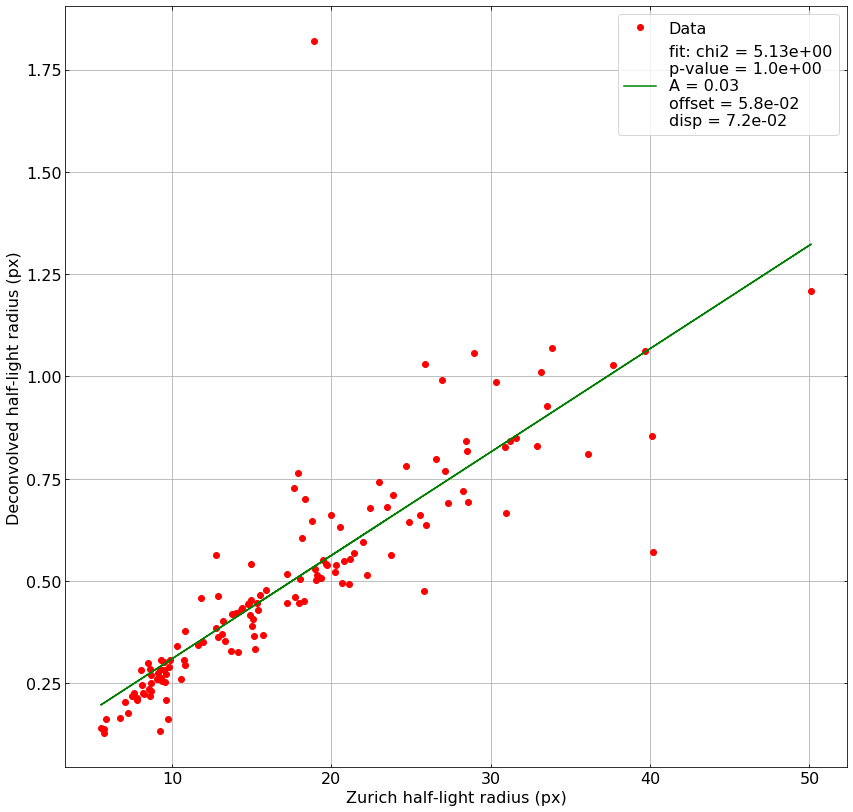

In [9]:
#Plotting Deconvolved radius from Zurich against Zurich radius
plt.rcParams["figure.figsize"] = (14, 14) # (w, h)

f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', direction='in', labelsize=16)
plt.grid()

#Transform Zurich radius from pixel to arcsec
# if R_half_Zurich2.unit == "pix":
#     R_half_Zurich2 *= 0.03
#     R_half_Zurich2.unit = "arcsec"

#Compute linear fit and perform chi-square test
(A, offset), pcov  = curve_fit(linear_fit, R_half_Zurich2, R_half_Deconv2, p0=[0.5, 1], check_finite=True)
sep_lin_fit        = linear_fit(R_half_Zurich2, A, offset)
chisq, pval        = chisquare(R_half_Deconv2, sep_lin_fit, ddof=2)

#Plot data
plt.plot(R_half_Zurich2, R_half_Deconv2, "ro", label="Data")

#Compute dispersion
disp = np.mean(np.abs(R_half_Deconv2-sep_lin_fit))

#Plot best fit
string = "fit: chi2 = %.2e\np-value = %.1e\nA = %.2f\noffset = %.1e\ndisp = %.1e" %(chisq, pval, A, offset, disp)
plt.plot(R_half_Zurich2, sep_lin_fit, "g", label=string)

plt.ylabel("Deconvolved half-light radius (px)", size=16)
plt.xlabel("Zurich half-light radius (px)", size=16)
plt.legend(loc='best', prop={'size': 16})

print("A = %.1f" %A, "\noffset = %.1e" %offset, "\ndisp = %.1e" %disp,
      "\np-value = %.2e" %pval)

# f.savefig("Plots/deconvolvedRadius_against_zurichRadius.pdf", bbox_inches='tight')


### PLOTTING SECTION between Zurich/Cassata/Tasca data against GF###


In [9]:
#Remove incorrect values in GalFit radius column
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)

#Remove nan values in all arrays
mask2      = maskToRemoveVal([table['R50_ZURICH'], 
                         table['R_d_GF'], table['R_HALF_CASSATA'], 
                         table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                         table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                         table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                         table['CLASS_LINEE_TASCA'], table['TYPE_ZURICH']])

#Remove too large values in CASSATA (high probability they are wrong)
m          = table['R_HALF_CASSATA']<50

#Keep values for which the morphological classes between catalogs are the same
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA']) == table['TYPE_ZURICH']
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA'])
# classMask  = table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']
classMask  = table['AUTOCLASS_CASSATA'] == table['AUTOCLASS_CASSATA']

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(mask, mask2), m), classMask)

#Apply master mask and retrieve data
R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich = applyMask([table['R50_ZURICH'], 
                                              table['R_d_GF'], table['R_HALF_CASSATA'], 
                                              table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                                              table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                                              table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                                              table['CLASS_SVM_TASCA'], table['TYPE_ZURICH']], 
                                              masterMask)

#Change unit of deconvolved radius array from arcsec to pixel
R_half_Deconv  /= 0.03

#Checking everything is ok
findWhereIsValue([GF_R], val=999)
findWhereIsValue([GF_R], val=50)
findWhereIsValue([R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, 
                  classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich])

No value 999 found within array number 0
No value 50 found within array number 0
No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No nan was found in array number 6
No nan was found in array number 7
No nan was found in array number 8
No nan was found in array number 9
No nan was found in array number 10


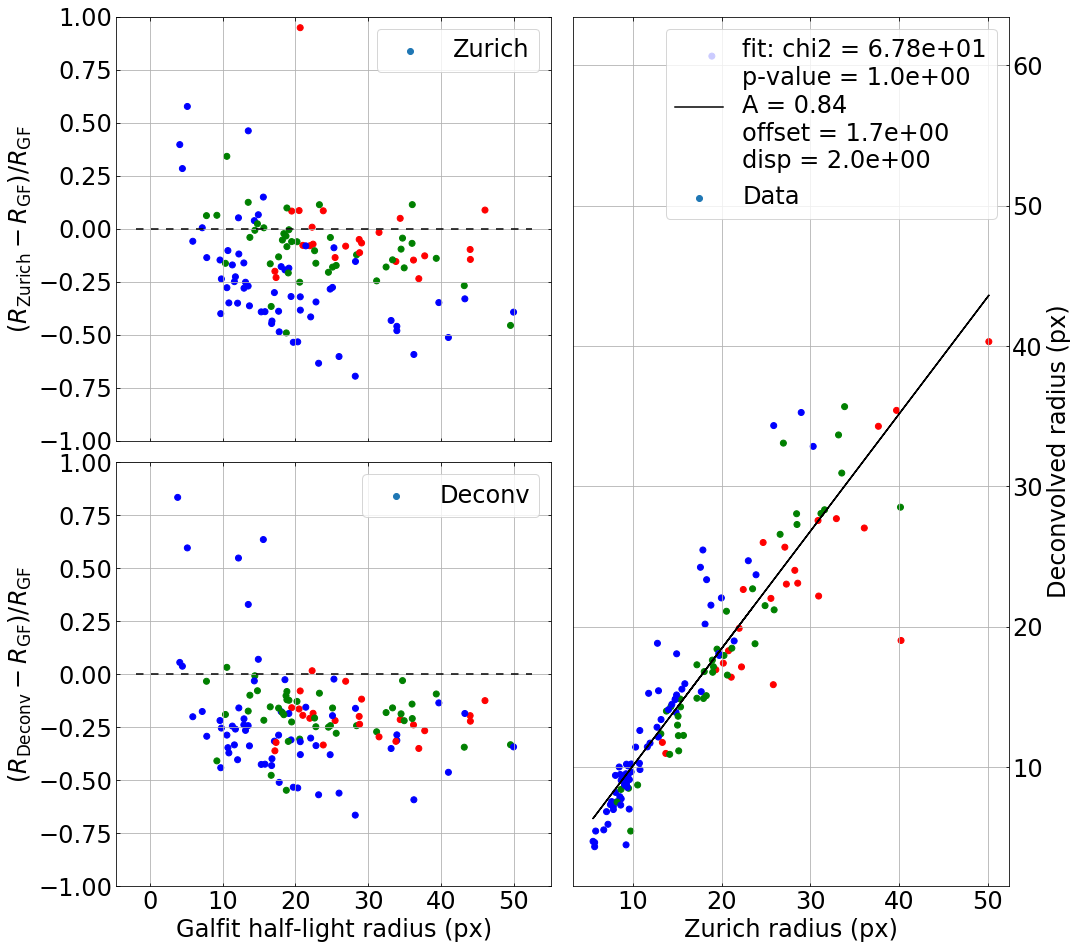

In [11]:
## Comparing plots between Zurich's and deconvolved radii

plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

#Plotting Zurich against GF radius
f   = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

#Creating a cmap for colour plotting
newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['blue', 'green', 'red'])

#Plotting Zurich
ax, tmp = asManyPlots(221, GF_R, (R_half_Zurich - GF_R)/GF_R, ylim=[-1, 1], color=classCassata, cmap=newcmap,
            marker='o', label='Zurich', ylabel=r"$ (R_{\rm{Zurich}} - R_{\rm{GF}})/R_{\rm{GF}}$",
            legendTextSize=24, hideXlabel=True, textsize=24, showLegend=True, plotFlag=False)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting deconvolved radius
ax, tmp = asManyPlots(223, GF_R, (R_half_Deconv - GF_R)/GF_R, ylim=[-1, 1], color=classCassata, cmap=newcmap,
            marker='o', label='Deconv', ylabel=r"$ (R_{\rm{Deconv}} - R_{\rm{GF}})/R_{\rm{GF}}$",
            legendTextSize=24, xlabel="Galfit half-light radius (px)", textsize=24, showLegend=True,
            plotFlag=False)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting one against the other
ax, obj = asManyPlots(122, R_half_Zurich, R_half_Deconv, label="Data",
                 marker='o', ylabel="Deconvolved radius (px)", color=classCassata, cmap=newcmap,
                 legendTextSize=24, xlabel="Zurich radius (px)", textsize=24,
                 placeYaxisOnRight=True, plotFlag=False)

#Removing the upper point for linear fitting
msk = R_half_Deconv<60

#Compute linear fit and perform chi-square test
(A, offset), pcov  = curve_fit(linear_fit, R_half_Zurich[msk], R_half_Deconv[msk], p0=[0.5, 1], check_finite=True)
sep_lin_fit        = linear_fit(R_half_Zurich[msk], A, offset)
chisq, pval        = chisquare(R_half_Deconv[msk], sep_lin_fit, ddof=2)

#Compute dispersion
disp = np.mean(np.abs(R_half_Deconv[msk]-sep_lin_fit))

#Plot best fit
string = "fit: chi2 = %.2e\np-value = %.1e\nA = %.2f\noffset = %.1e\ndisp = %.1e" %(chisq, pval, A, offset, disp)
ax.plot(R_half_Zurich[msk], sep_lin_fit, "k", label=string)

ax.legend(loc='best', prop={'size': 24})

# f.savefig("Plots/plotsWithColourCoding/zurichAndDeconvolvedRadii_against_Galfit_colourCodedWithCassataType.pdf", bbox_inches='tight')


### Comparing catalogs morphological types ###


In [13]:
#classCassata    = table['AUTOCLASS_CASSATA'][mask][mask2][m][mask3]
#classTascaInt   = table['CLASS_INT_TASCA'][mask][mask2][m][mask3]
#classTascaLinee = table['CLASS_LINEE_TASCA'][mask][mask2][m][mask3]
#classTascaSVM   = table['CLASS_SVM_TASCA'][mask][mask2][m][mask3]
#classZurich     = table['TYPE_ZURICH'][mask][mask2][m][mask3]

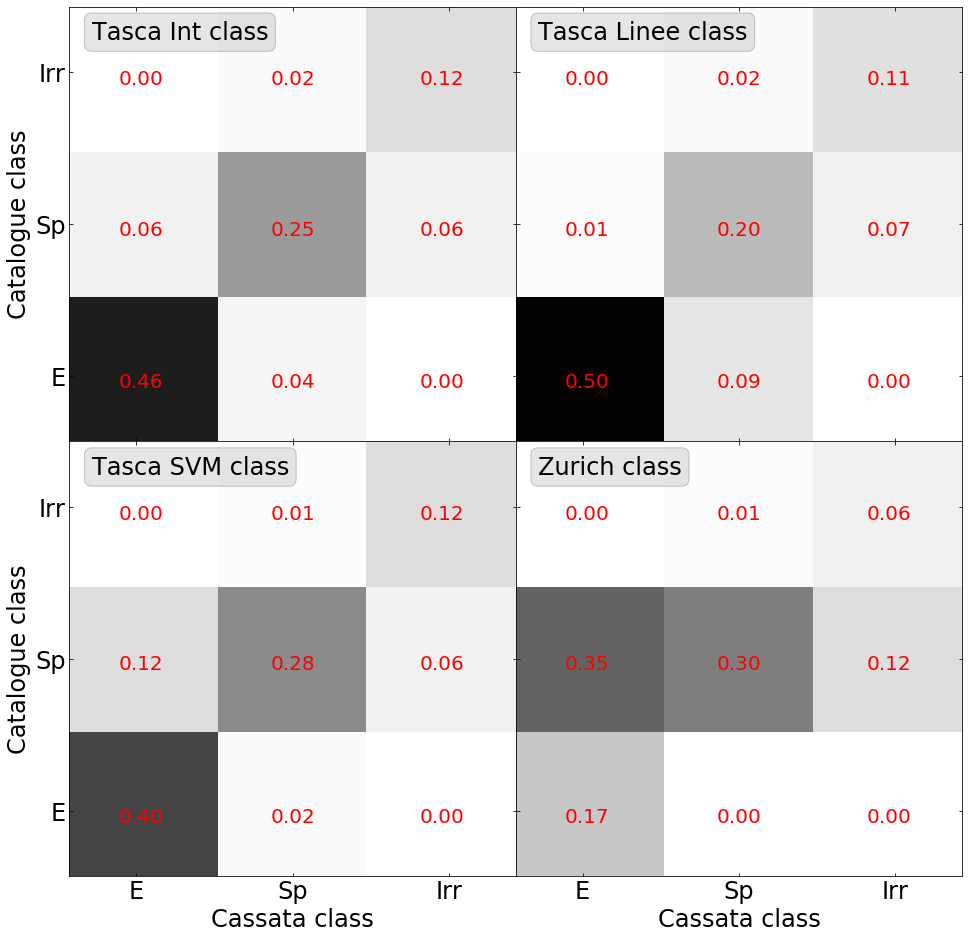

In [14]:
## Checking types are similar between catalogs

plt.rcParams["figure.figsize"] = (16, 16)

f = plt.figure()
plt.subplots_adjust(wspace=0.0, hspace=0.0)

def onePlot(numPlot, datax, datay, hideXlabel=False, hideYlabel=False, vmax=None, vmin=None,
            hideColorbar=True, placeYaxisOnRight=False, 
            xlabel="Cassata class", ylabel='Tasca Int class'):
    
    ax1 = plt.subplot(numPlot)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(which='both', direction='in', labelsize=24)
    plt.xticks([1.3, 2, 2.7], ['E', 'Sp', 'Irr'])
    plt.yticks([1.3, 2, 2.7], ['E', 'Sp', 'Irr'])
    plt.grid()
    
    #hiding labels if required
    if hideXlabel:
        ax1.axes.get_xaxis().set_ticklabels([])
    else:
        plt.xlabel(xlabel, size=24)
        
    if hideYlabel:
        ax1.axes.get_yaxis().set_ticklabels([])
    else:
        plt.ylabel(ylabel, size=24)
    
    if placeYaxisOnRight:
        ax1.yaxis.set_label_position("right")

    #setting colorbar limits
    if vmax is None:
        vmax = 70
    if vmin is None:
        vmin = 0

    hist, xed, yed, im = plt.hist2d(datax, datay, bins=3, vmax=vmax, vmin=vmin, cmap='Greys')
    
    #hiding colorbar if required
    if not hideColorbar:
        plt.colorbar(im)

    for i, posi in enumerate([1.22, 1.90, 2.57]):
        for j, posj in enumerate([1.25, 1.95, 2.64]):
            text = "%1.2f" %np.round(hist[i][j]/np.sum(hist), 2)
            plt.text(posi, posj, text, size=20, color='red')
          
    
    return im

im1 = onePlot(221, classCassata, classTascaInt, hideXlabel=True, ylabel="Catalogue class")
sometext = plt.text(1.1, 2.85, "Tasca Int class", size=24)
sometext.set_bbox(dict(facecolor='grey', alpha=0.2, boxstyle='round', edgecolor='black'))

im1 = onePlot(222, classCassata, classTascaLinee, hideXlabel=True, hideYlabel=True,
              placeYaxisOnRight=True)
sometext = plt.text(1.1, 2.85, "Tasca Linee class", size=24)
sometext.set_bbox(dict(facecolor='grey', alpha=0.2, boxstyle='round', edgecolor='black'))

im1 = onePlot(223, classCassata, classTascaSVM, ylabel='Catalogue class')
sometext = plt.text(1.1, 2.85, "Tasca SVM class", size=24)
sometext.set_bbox(dict(facecolor='grey', alpha=0.2, boxstyle='round', edgecolor='black'))

im1 = onePlot(224, classCassata, classZurich, hideYlabel=True,
             placeYaxisOnRight=True)
sometext = plt.text(1.1, 2.85, "Zurich class", size=24)
sometext.set_bbox(dict(facecolor='grey', alpha=0.2, boxstyle='round', edgecolor='black'))

#f.savefig("Plots/comparisonClassTypes.pdf", bbox_inches='tight')


# Plotting against GalFit half-light radius with colour coding on galaxy type ###


In [15]:
#Remove incorrect values in GalFit radius column
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)
#Remove nan values in all arrays
mask2      = maskToRemoveVal([table['R50_ZURICH'], 
                         table['R_d_GF'], table['R_HALF_CASSATA'], 
                         table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                         table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                         table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                         table['CLASS_LINEE_TASCA'], table['TYPE_ZURICH']])
#Remove too large values in CASSATA (high probability they are wrong)
m          = table['R_HALF_CASSATA']<50
#Keep values for which the morphological classes between catalogs are the same
# classMask  = (((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA']) == table['TYPE_ZURICH']) == table['CLASS_SVM_TASCA']
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA'])
# classMask  = table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']
classMask  = table['AUTOCLASS_CASSATA'] == table['AUTOCLASS_CASSATA']

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(mask, mask2), m), classMask)


#Apply master mask and retrieve data
R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich = applyMask([table['R50_ZURICH'], 
                                              table['R_d_GF'], table['R_b_GF'], table['R_HALF_CASSATA'], 
                                              table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                                              table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                                              table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                                              table['CLASS_SVM_TASCA'], table['TYPE_ZURICH']], 
                                              masterMask)

#Change unit of deconvolved radius array from arcsec to pixel
R_half_Deconv  /= 0.03

#Checking everything is ok
findWhereIsValue([GF_R], val=999)
findWhereIsValue([GF_R], val=50)
findWhereIsValue([R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, 
                  classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich])

# classCassata = classZurich

No value 999 found within array number 0
No value 50 found within array number 0
No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No nan was found in array number 6
No nan was found in array number 7
No nan was found in array number 8
No nan was found in array number 9
No nan was found in array number 10


[False, False, False, False, False, False, False, False, False, False, False]

71


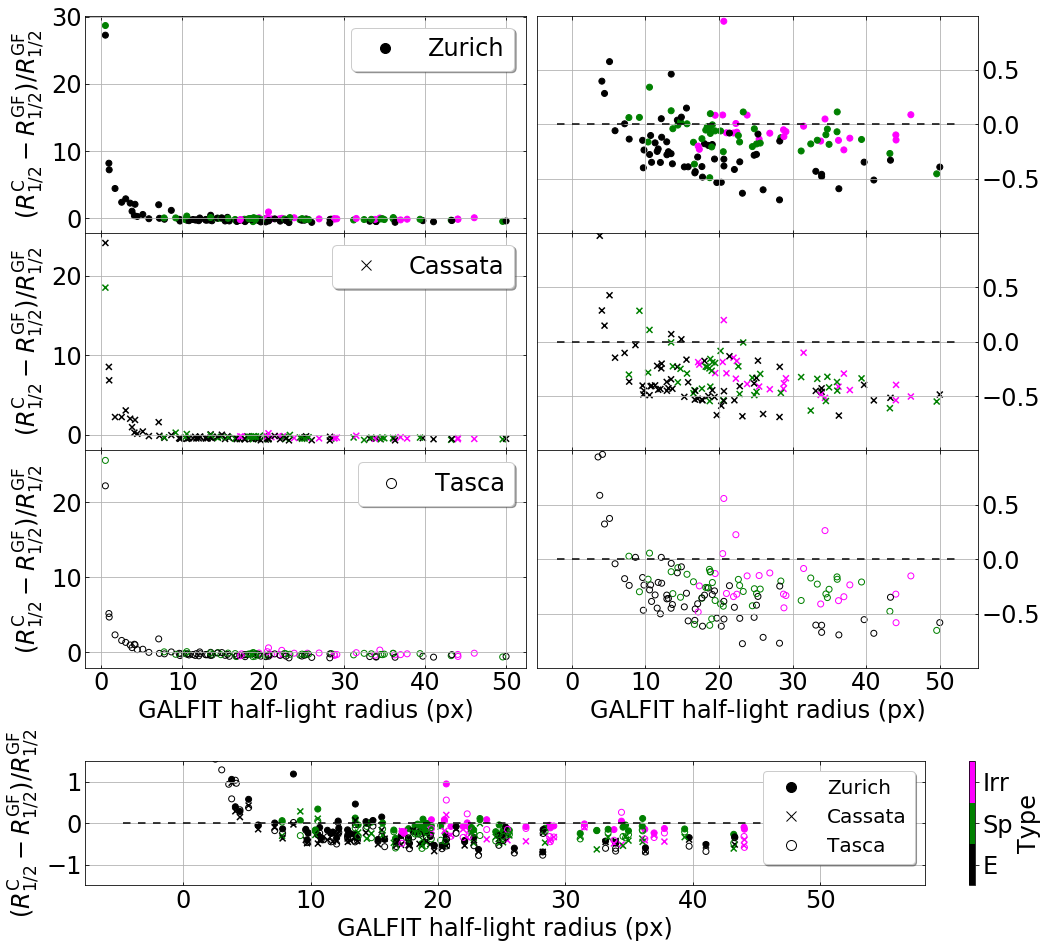

In [43]:
## Plotting the absolute difference in radii between Catalogs and GalFit radii against GalFit (in px)
from stage2 import *
import matplotlib.lines as mlines

plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

f   = plt.figure()
plt.subplots_adjust(wspace=0.025, hspace=0)

newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['black', 'green', 'magenta'])

#Left plot for Zurich
ax, tmp = asManyPlots(421, GF_R, (R_half_Zurich - GF_R)/GF_R, hideXlabel=True, label='Zurich',
            ylabel=r"$(R_{1/2}^{\rm{C}} - R_{1/2}^{\rm{GF}} )/ R_{1/2}^{\rm{GF}}$", marker="o",
            plotFlag=False, cmap=newcmap, color=[classCassata], cmapMin=0.5, cmapMax=3.5,
            showLegend=True)
Zurich  = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Zurich', linestyle='None')
plt.legend(handles=[Zurich], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)

#Left plot for Cassata
ax, tmp = asManyPlots(423, GF_R, (R_half_CASSATA - GF_R)/GF_R, hideXlabel=True, label='Cassata',
            ylabel=r"$(R_{1/2}^{\rm{C}} - R_{1/2}^{\rm{GF}} )/ R_{1/2}^{\rm{GF}}$", marker='x',
            plotFlag=False, cmap=newcmap, color=[classCassata], cmapMin=0.5, cmapMax=3.5,
            showLegend=True)
Cassata = mlines.Line2D([], [], color='black', marker='x', markersize=10, label='Cassata', linestyle='None')
plt.legend(handles=[Cassata], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)

#Left plot for Tasca
ax, tmp = asManyPlots(425, GF_R, (R_half_TASCA - GF_R)/GF_R, label='Tasca', marker="o",
            ylabel=r"$(R_{1/2}^{\rm{C}} - R_{1/2}^{\rm{GF}} )/ R_{1/2}^{\rm{GF}}$", 
            xlabel="GALFIT half-light radius (px)",
            plotFlag=False, cmap=newcmap, color=[classCassata], cmapMin=0.5, cmapMax=3.5,
            unfilledFlag=True)
Tasca   = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Tasca', linestyle='None', fillstyle='none')
plt.legend(handles=[Tasca], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)

#Right plot for Zurich
ax, tmp = asManyPlots(422, GF_R, (R_half_Zurich - GF_R)/GF_R, hideXlabel=True, marker='o',
            ylabel=r"$(R_{1/2}^{\rm{C}} - R_{1/2}^{\rm{GF}} )/ R_{1/2}^{\rm{GF}}$", hideYlabel=True,
            placeYaxisOnRight=True, ylim=[-1, 1],
            plotFlag=False, cmap=newcmap, color=[classCassata], cmapMin=0.5, cmapMax=3.5)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.set_yticks([-0.5, 0.0, 0.5])

#Right plot for Cassata
ax, tmp = asManyPlots(424, GF_R, (R_half_CASSATA - GF_R)/GF_R, hideXlabel=True, marker='x',
            ylabel=r"$(R_{1/2}^{\rm{C}} - R_{1/2}^{\rm{GF}} )/ R_{1/2}^{\rm{GF}}$", hideYlabel=True,
            placeYaxisOnRight=True, ylim=[-1, 1],
            plotFlag=False, cmap=newcmap, color=[classCassata], cmapMin=0.5, cmapMax=3.5)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.set_yticks([-0.5, 0.0, 0.5])

#Right plot for Tasca
ax, tmp = asManyPlots(426, GF_R, (R_half_TASCA - GF_R)/GF_R, label='Tasca', marker='o', hideYlabel=True,
            xlabel="GALFIT half-light radius (px)", placeYaxisOnRight=True, ylim=[-1, 1],
            plotFlag=False, cmap=newcmap, color=[classCassata], cmapMin=0.5, cmapMax=3.5,
            unfilledFlag=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.set_yticks([-0.5, 0.0, 0.5])

#Last subplot
ax7 = f.add_subplot(717)
ax7.yaxis.set_ticks_position('both')
ax7.xaxis.set_ticks_position('both')
ax7.tick_params(which='both', direction='in', labelsize=24)
ax7.set_ylim(top=1.5, bottom=-1.5)
plt.grid()
ax7.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plot data
plt.scatter(GF_R, (R_half_Zurich - GF_R)/GF_R, label="Zurich", c=classCassata,  marker='o',
            vmin=0.5, vmax=3.5, cmap=newcmap)
plt.scatter(GF_R, (R_half_CASSATA - GF_R)/GF_R, label="Cassata", c=classCassata, 
            marker='x', vmin=0.5, vmax=3.5, cmap=newcmap)
ret = plt.scatter(GF_R, (R_half_TASCA - GF_R)/GF_R, label="Tasca", c=classCassata, 
                  marker='o', vmin=0.5, vmax=3.5, cmap=newcmap)
ret.set_facecolor('none')

col = plt.colorbar(ret, fraction=0.01)

col.set_ticks([1, 2, 3])
col.ax.set_yticklabels(['E', 'Sp', 'Irr'], size=24)
col.set_label("Type", size=24)

plt.xlabel("GALFIT half-light radius (px)", size=24)
plt.ylabel(r"$  (R_{1/2}^{\rm{C}} - R_{1/2}^{\rm{GF}}) / R_{1/2}^{\rm{GF}}$", size=24)

Cassata = mlines.Line2D([], [], color='black', marker='x', markersize=10, label='Cassata', linestyle='None')
Zurich  = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Zurich', linestyle='None')
Tasca   = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Tasca', linestyle='None', fillstyle='none')
plt.legend(handles=[Zurich, Cassata, Tasca], loc='best', prop={'size': 20}, shadow=True, fancybox=True).set_zorder(1000)

#plt.legend(loc='best', prop={'size': 16}, shadow=True, fancybox=True).set_zorder(1000)

print(len(classCassata[classCassata==1]))

# f.savefig("Plots/plotsWithColourCoding/relErr_against_GalFit1.5LightRadius_colourCoded_matchAllTypes.pdf", bbox_inches='tight')
f.savefig("Plots/plotsWithColourCoding/relErr_against_GalFit1.5LightRadius_colourCoded_CassataType.pdf", bbox_inches='tight')
# f.savefig("Plots/plotsWithColourCoding/relErr_against_GalFit1.5LightRadius_colourCoded_zurichType.pdf", bbox_inches='tight')


### Correcting Cassata radii to have a linear relation of slope 1 with GalFit ###


In [9]:
#Remove incorrect values in GalFit radius column
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)
#Remove nan values in all arrays
mask2      = maskToRemoveVal([table['R50_ZURICH'], 
                         table['R_d_GF'], table['R_HALF_CASSATA'], 
                         table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                         table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                         table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                         table['CLASS_LINEE_TASCA'], table['TYPE_ZURICH']])
#Remove too large values in CASSATA (high probability they are wrong)
m          = table['R_HALF_CASSATA']<50
#Keep values for which the morphological classes between catalogs are the same
# classMask  = (((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA']) == table['TYPE_ZURICH']) == table['CLASS_SVM_TASCA']
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA'])
# classMask  = table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']
classMask  = table['AUTOCLASS_CASSATA'] == table['AUTOCLASS_CASSATA']

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(mask, mask2), m), classMask)


#Apply master mask and retrieve data
R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich = applyMask([table['R50_ZURICH'], 
                                              table['R_d_GF'], table['R_b_GF'], table['R_HALF_CASSATA'], 
                                              table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                                              table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                                              table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                                              table['CLASS_SVM_TASCA'], table['TYPE_ZURICH']], 
                                              masterMask)

#Change unit of deconvolved radius array from arcsec to pixel
R_half_Deconv  /= 0.03

#Checking everything is ok
findWhereIsValue([GF_R], val=999)
findWhereIsValue([GF_R], val=50)
findWhereIsValue([R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, 
                  classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich])

# classCassata = classZurich

No value 999 found within array number 0
No value 50 found within array number 0
No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No nan was found in array number 6
No nan was found in array number 7
No nan was found in array number 8
No nan was found in array number 9
No nan was found in array number 10


In [26]:
#Computing a linear fit to Cassata plot
msk = np.logical_and(R_half_CASSATA>5, ((R_half_CASSATA - GF_R)/GF_R)<0.75)
msk = np.logical_and(GF_R>5, R_half_CASSATA>5)

(A, offset), pcov  = curve_fit(linear_fit, GF_R[msk], 
                               R_half_CASSATA[msk], 
                               p0=[1.0, 0.0], check_finite=True)
sep_lin_fit        = linear_fit(GF_R[msk], A, offset)
chisq, pval        = chisquare(R_half_CASSATA[msk], sep_lin_fit, ddof=2)
print("A, offset = %.3e, %.3e" %(A, offset))
print("chi2, pval = %.3e, %.3e" %(chisq, pval))

A, offset = 4.379e-01, 4.048e+00
chi2, pval = 1.255e+02, 3.950e-01


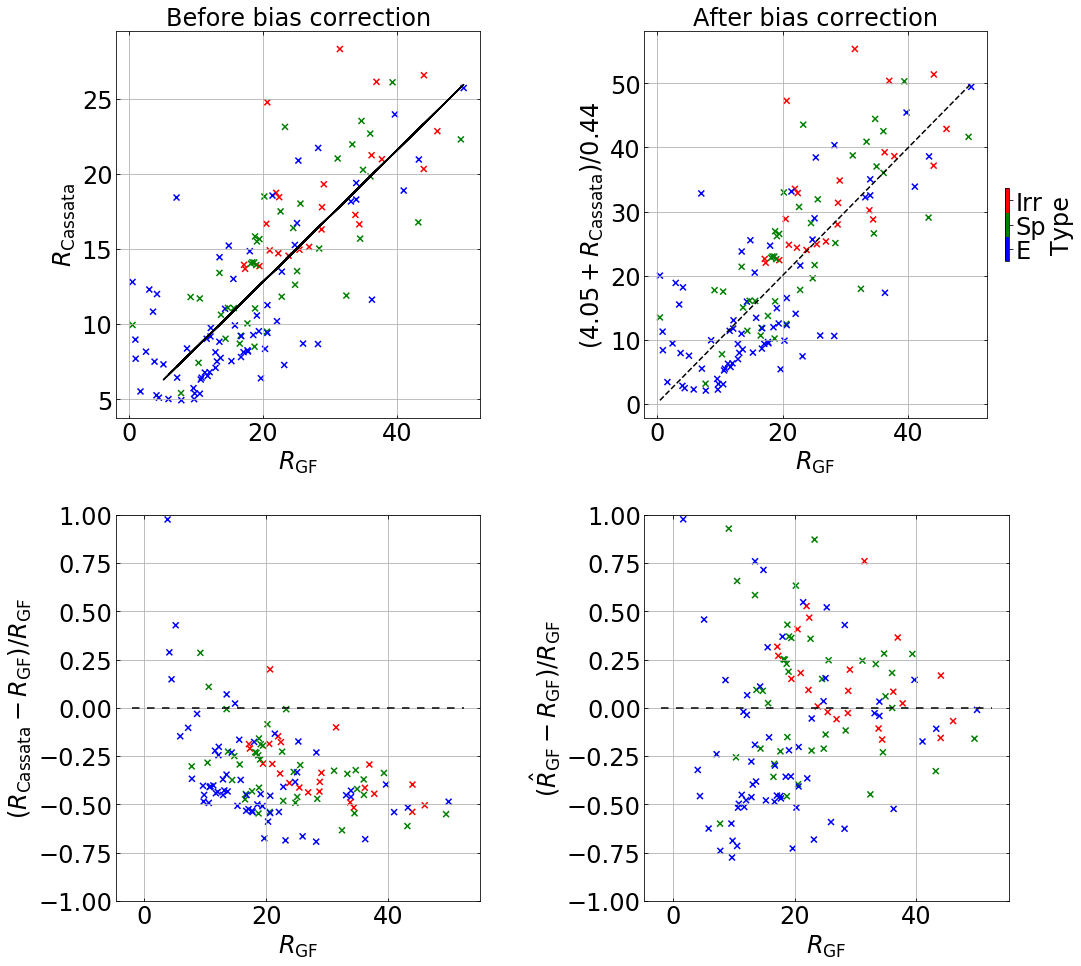

In [49]:
## Plotting the absolute difference in radii between Catalogs and GalFit radii against GalFit (in px)

plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

f   = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.25)

newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['blue', 'green', 'red'])

## Bottom plots
#Left plot for Cassata
ylabel=r"$(R_{\rm{Cassata}} - R_{\rm{GF}}) / R_{\rm{GF}}$"
ax, tmp = asManyPlots(223, GF_R, (R_half_CASSATA - GF_R)/GF_R,
                      ylabel=ylabel, marker='x', xlabel=r'$R_{\rm{GF}}$', ylim=[-1, 1],
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Right plot for Cassata
sign="-"
if offset*A<0:
    sign  = "+"
ofset = np.abs(offset)
AA    = np.abs(A)
ylabel=r"$(\hat{R}_{\rm{GF}} - R_{\rm{GF}})/ R_{\rm{GF}}$"
ax, tmp = asManyPlots(224, GF_R, ((R_half_CASSATA - offset)/A - GF_R)/GF_R, marker='x',
                      ylabel=ylabel, ylim=[-1, 1], xlabel=r'$R_{\rm{GF}}$',
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)


## Top plots
#Left plot for Cassata
ax, tmp = asManyPlots(221, GF_R, R_half_CASSATA,
                      ylabel=r'$R_{\rm{Cassata}}$', marker='x', xlabel=r'$R_{\rm{GF}}$',
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)
ax.plot(GF_R[msk], sep_lin_fit, 'k')
ax.set_title("Before bias correction", size=24)

#Right plot for Cassata
# ylabel=r"$%1.1f + \sqrt{%1.1f + %1.1f R_{\rm{GF}}}$" %(-(offset+1)/(2*A), ((offset+1)/(2*A))**2, 1.0/A)
sign1 = ""
sign2 = ""
if offset < 0:
    offset = np.abs(offset)
    sign2="-"
if A < 0:
    sign1="-"
ylabel=r"$%s(%s%1.2f + R_{\rm{Cassata}})/%1.2f$" %(sign1, sign2, offset, A)
ax, tmp = asManyPlots(222, GF_R, (R_half_CASSATA - offset)/A, 
                      marker='x',
                      ylabel=ylabel, xlabel=r'$R_{\rm{GF}}$',
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)
plt.plot([np.min(GF_R), np.max(GF_R)], linear_fit(np.array([np.min(GF_R), np.max(GF_R)]), 1, 0), "--", color='black')
ax.set_title("After bias correction", size=24)

#Plot data
col = plt.colorbar(tmp, fraction=0.01)
col.set_ticks([1, 2, 3])
col.ax.set_yticklabels(['E', 'Sp', 'Irr'], size=24)
col.set_label("Type", size=24)

# f.savefig("Plots/plotsWithColourCoding/correctingCassataRadius.pdf", bbox_inches='tight')


### Correcting bias to have a linear relation of slope 1 with GalFit ###


In [60]:
#Remove incorrect values in GalFit radius column
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)
#Remove nan values in all arrays
mask2      = maskToRemoveVal([table['R50_ZURICH'], 
                         table['R_d_GF'], table['R_HALF_CASSATA'], 
                         table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                         table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                         table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                         table['CLASS_LINEE_TASCA'], table['TYPE_ZURICH']])
#Remove too large values in CASSATA (high probability they are wrong)
m          = table['R_HALF_CASSATA']<50
#Keep values for which the morphological classes between catalogs are the same
# classMask  = (((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA']) == table['TYPE_ZURICH']) == table['CLASS_SVM_TASCA']
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA'])
# classMask  = table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']
classMask  = table['AUTOCLASS_CASSATA'] == table['AUTOCLASS_CASSATA']

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(mask, mask2), m), classMask)


#Apply master mask and retrieve data
R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich = applyMask([table['R50_ZURICH'], 
                                              table['R_d_GF'], table['R_b_GF'], table['R_HALF_CASSATA'], 
                                              table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                                              table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                                              table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                                              table['CLASS_SVM_TASCA'], table['TYPE_ZURICH']], 
                                              masterMask)

#Change unit of deconvolved radius array from arcsec to pixel
R_half_Deconv  /= 0.03

#Checking everything is ok
findWhereIsValue([GF_R], val=999)
findWhereIsValue([GF_R], val=50)
findWhereIsValue([R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, 
                  classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich])

# classCassata = classZurich

No value 999 found within array number 0
No value 50 found within array number 0
No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No nan was found in array number 6
No nan was found in array number 7
No nan was found in array number 8
No nan was found in array number 9
No nan was found in array number 10


In [69]:
#Computing a linear fit to Cassata plot
msk = np.logical_and(R_half_CASSATA>5, ((R_half_CASSATA - GF_R)/GF_R)<0.75)

(A, offset), pcov  = curve_fit(linear_fit, R_half_CASSATA[msk], 
                               ((R_half_CASSATA-GF_R)/GF_R)[msk], 
                               p0=[1.0, 0.0], check_finite=True)
sep_lin_fit        = linear_fit(R_half_CASSATA[msk], A, offset)
chisq, pval        = chisquare(((R_half_CASSATA-GF_R)/GF_R)[msk], sep_lin_fit, ddof=2)
print("A, offset = %.3e, %.3e" %(A, offset))
print("chi2, pval = %.3e, %.3e" %(chisq, pval))

A, offset = 3.206e-03, -3.858e-01
chi2, pval = -1.517e+01, 1.000e+00


Median value after correction: -0.0786087455959599
Mean value after correction: -0.027215860562679318
Standard Deviation after correction: 0.22144854743074466


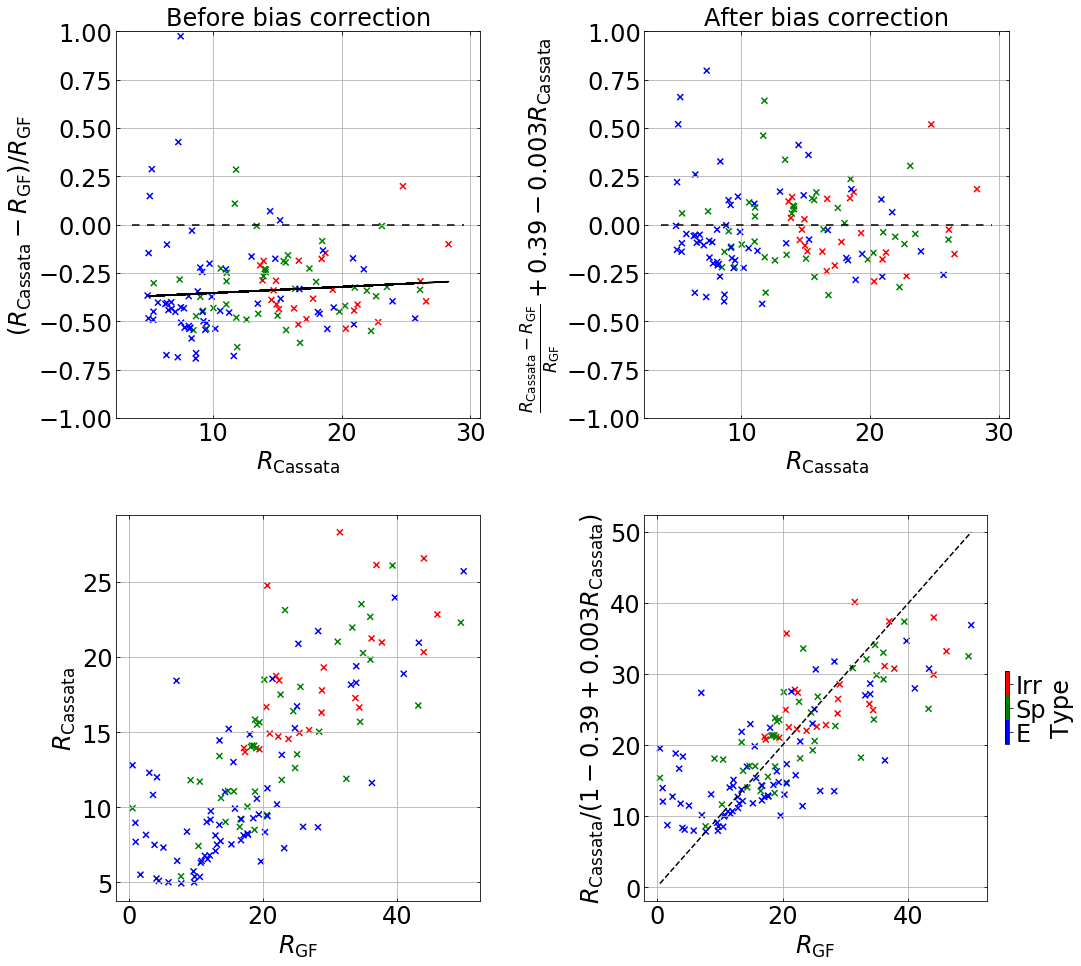

In [86]:
## Plotting the absolute difference in radii between Catalogs and GalFit radii against GalFit (in px)

plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

f   = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.25)

newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['blue', 'green', 'red'])

## Bottom plots
#Left plot for Cassata
ylabel=r"$(R_{\rm{Cassata}} - R_{\rm{GF}}) / R_{\rm{GF}}$"
ax, tmp = asManyPlots(221, R_half_CASSATA, (R_half_CASSATA - GF_R)/GF_R,
                      ylabel=ylabel, marker='x', xlabel=r'$R_{\rm{Cassata}}$', ylim=[-1, 1],
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.plot(R_half_CASSATA[msk], sep_lin_fit, 'k')
ax.set_title("Before bias correction", size=24)

#Right plot for Cassata
sign1="-"
sign2="-"
if offset<0:
    sign1 = "+"
if A<0:
    sign2 = "+"
ofset = np.abs(offset)
AA    = np.abs(A)
ylabel=r"$\frac{R_{\rm{Cassata}} - R_{\rm{GF}}}{R_{\rm{GF}}} %s %1.2f %s %1.3fR_{\rm{Cassata}}$" %(sign1, ofset, 
                                                                                                sign2, AA)
ax, tmp = asManyPlots(222, R_half_CASSATA, (R_half_CASSATA-GF_R)/GF_R - offset - A*GF_R, marker='x',
                      ylabel=ylabel, ylim=[-1, 1], xlabel=r'$R_{\rm{Cassata}}$',
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.set_title("After bias correction", size=24)


## Top plots
#Left plot for Cassata
ax, tmp = asManyPlots(223, GF_R, R_half_CASSATA,
                      ylabel=r'$R_{\rm{Cassata}}$', marker='x', xlabel=r'$R_{\rm{GF}}$',
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)

#Right plot for Cassata
# ylabel=r"$%1.1f + \sqrt{%1.1f + %1.1f R_{\rm{GF}}}$" %(-(offset+1)/(2*A), ((offset+1)/(2*A))**2, 1.0/A)
sign1 = "+"
sign2 = "+"
if offset < 0:
    sign2="-"
if A < 0:
    sign1="-"
ylabel=r"$R_{\rm{Cassata}}/(1 %s %1.2f %s %1.3fR_{\rm{Cassata}})$" %(sign2, ofset, sign1, AA)
ax, tmp = asManyPlots(224, GF_R, R_half_CASSATA/(1+offset+A*R_half_CASSATA), 
                      marker='x',
                      ylabel=ylabel, xlabel=r'$R_{\rm{GF}}$',
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)
plt.plot([np.min(GF_R), np.max(GF_R)], linear_fit(np.array([np.min(GF_R), np.max(GF_R)]), 1, 0), "--", color='black')

#Plot data
col = plt.colorbar(tmp, fraction=0.01)
col.set_ticks([1, 2, 3])
col.ax.set_yticklabels(['E', 'Sp', 'Irr'], size=24)
col.set_label("Type", size=24)

# f.savefig("Plots/plotsWithColourCoding/correctingBiaisInCassataRadius.pdf", bbox_inches='tight')

relevant_data = ((R_half_CASSATA-GF_R)/GF_R - offset - A*GF_R)[msk]
print("Median value after correction:", np.median(relevant_data))
print("Mean value after correction:", np.mean(relevant_data))
print("Standard Deviation after correction:", np.std(relevant_data))


### Correcting bias with spiral gals only to have a linear relation of slope 1 with GalFit ###


In [60]:
#Remove incorrect values in GalFit radius column
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)
#Remove nan values in all arrays
mask2      = maskToRemoveVal([table['R50_ZURICH'], 
                         table['R_d_GF'], table['R_HALF_CASSATA'], 
                         table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                         table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                         table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                         table['CLASS_LINEE_TASCA'], table['TYPE_ZURICH']])
#Remove too large values in CASSATA (high probability they are wrong)
m          = table['R_HALF_CASSATA']<50
#Keep values for which the morphological classes between catalogs are the same
# classMask  = (((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA']) == table['TYPE_ZURICH']) == table['CLASS_SVM_TASCA']
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA'])
# classMask  = table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']
classMask  = table['AUTOCLASS_CASSATA'] == table['AUTOCLASS_CASSATA']

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(mask, mask2), m), classMask)


#Apply master mask and retrieve data
R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich = applyMask([table['R50_ZURICH'], 
                                              table['R_d_GF'], table['R_b_GF'], table['R_HALF_CASSATA'], 
                                              table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                                              table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                                              table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                                              table['CLASS_SVM_TASCA'], table['TYPE_ZURICH']], 
                                              masterMask)

#Change unit of deconvolved radius array from arcsec to pixel
R_half_Deconv  /= 0.03

#Checking everything is ok
findWhereIsValue([GF_R], val=999)
findWhereIsValue([GF_R], val=50)
findWhereIsValue([R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, 
                  classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich])

# classCassata = classZurich

No value 999 found within array number 0
No value 50 found within array number 0
No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No nan was found in array number 6
No nan was found in array number 7
No nan was found in array number 8
No nan was found in array number 9
No nan was found in array number 10


In [93]:
classCassata

2
1
1
3
1
2
3
1
1
1
3


In [94]:
#Computing a linear fit to Cassata plot
msk = np.logical_and(np.logical_and(R_half_CASSATA>5, ((R_half_CASSATA - GF_R)/GF_R)<0.75),
                     classCassata==2)
# msk = np.logical_and(R_half_CASSATA>5, ((R_half_CASSATA - GF_R)/GF_R)<0.75)

(A, offset), pcov  = curve_fit(linear_fit, R_half_CASSATA[msk], 
                               ((R_half_CASSATA-GF_R)/GF_R)[msk], 
                               p0=[1.0, 0.0], check_finite=True)
sep_lin_fit        = linear_fit(R_half_CASSATA[msk], A, offset)
chisq, pval        = chisquare(((R_half_CASSATA-GF_R)/GF_R)[msk], sep_lin_fit, ddof=2)
print("A, offset = %.3e, %.3e" %(A, offset))
print("chi2, pval = %.3e, %.3e" %(chisq, pval))

A, offset = 1.950e-03, -3.495e-01
chi2, pval = -4.602e+00, 1.000e+00


Median value after correction: -0.03868720379460375
Mean value after correction: -0.016397605277050704
Standard Deviation after correction: 0.1988671488125047


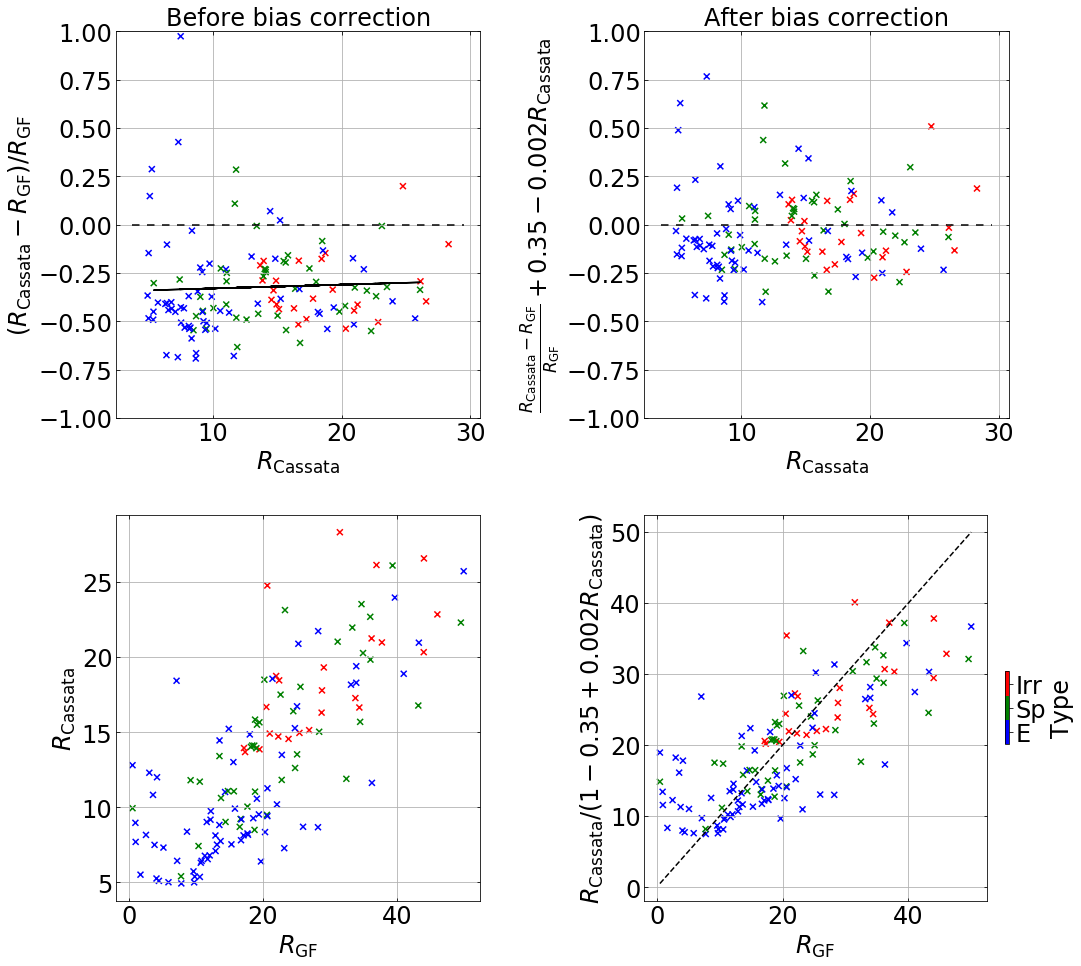

In [96]:
## Plotting the absolute difference in radii between Catalogs and GalFit radii against GalFit (in px)

plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

f   = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.25)

newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['blue', 'green', 'red'])

## Bottom plots
#Left plot for Cassata
ylabel=r"$(R_{\rm{Cassata}} - R_{\rm{GF}}) / R_{\rm{GF}}$"
ax, tmp = asManyPlots(221, R_half_CASSATA, (R_half_CASSATA - GF_R)/GF_R,
                      ylabel=ylabel, marker='x', xlabel=r'$R_{\rm{Cassata}}$', ylim=[-1, 1],
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.plot(R_half_CASSATA[msk], sep_lin_fit, 'k')
ax.set_title("Before bias correction", size=24)

#Right plot for Cassata
sign1="-"
sign2="-"
if offset<0:
    sign1 = "+"
if A<0:
    sign2 = "+"
ofset = np.abs(offset)
AA    = np.abs(A)
ylabel=r"$\frac{R_{\rm{Cassata}} - R_{\rm{GF}}}{R_{\rm{GF}}} %s %1.2f %s %1.3fR_{\rm{Cassata}}$" %(sign1, ofset, 
                                                                                                sign2, AA)
ax, tmp = asManyPlots(222, R_half_CASSATA, (R_half_CASSATA-GF_R)/GF_R - offset - A*GF_R, marker='x',
                      ylabel=ylabel, ylim=[-1, 1], xlabel=r'$R_{\rm{Cassata}}$',
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.set_title("After bias correction", size=24)


## Top plots
#Left plot for Cassata
ax, tmp = asManyPlots(223, GF_R, R_half_CASSATA,
                      ylabel=r'$R_{\rm{Cassata}}$', marker='x', xlabel=r'$R_{\rm{GF}}$',
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)

#Right plot for Cassata
# ylabel=r"$%1.1f + \sqrt{%1.1f + %1.1f R_{\rm{GF}}}$" %(-(offset+1)/(2*A), ((offset+1)/(2*A))**2, 1.0/A)
sign1 = "+"
sign2 = "+"
if offset < 0:
    sign2="-"
if A < 0:
    sign1="-"
ylabel=r"$R_{\rm{Cassata}}/(1 %s %1.2f %s %1.3fR_{\rm{Cassata}})$" %(sign2, ofset, sign1, AA)
ax, tmp = asManyPlots(224, GF_R, R_half_CASSATA/(1+offset+A*R_half_CASSATA), 
                      marker='x',
                      ylabel=ylabel, xlabel=r'$R_{\rm{GF}}$',
                      plotFlag=False, cmap=newcmap, color=classCassata, cmapMin=0.5, cmapMax=3.5)
plt.plot([np.min(GF_R), np.max(GF_R)], linear_fit(np.array([np.min(GF_R), np.max(GF_R)]), 1, 0), "--", color='black')

#Plot data
col = plt.colorbar(tmp, fraction=0.01)
col.set_ticks([1, 2, 3])
col.ax.set_yticklabels(['E', 'Sp', 'Irr'], size=24)
col.set_label("Type", size=24)

# f.savefig("Plots/plotsWithColourCoding/correctingBiaisInCassataRadiusWithSpirals.pdf", bbox_inches='tight')

relevant_data = ((R_half_CASSATA-GF_R)/GF_R - offset - A*GF_R)[msk]
print("Median value after correction:", np.median(relevant_data))
print("Mean value after correction:", np.mean(relevant_data))
print("Standard Deviation after correction:", np.std(relevant_data))


# Plotting against GalFit half-light radius (disk or bulge) with colour coding on galaxy type


In [8]:
#Remove incorrect values in GalFit radius column
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)
#Remove nan values in all arrays
mask2      = maskToRemoveVal([table['R50_ZURICH'], 
                         table['R_d_GF'], table['R_HALF_CASSATA'], 
                         table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                         table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                         table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                         table['CLASS_LINEE_TASCA'], table['TYPE_ZURICH']])
#Remove too large values in CASSATA (high probability they are wrong)
m          = table['R_HALF_CASSATA']<50
#Keep values for which the morphological classes between catalogs are the same
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA']) == table['TYPE_ZURICH']
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA'])
# classMask  = table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']
classMask  = table['AUTOCLASS_CASSATA'] == table['AUTOCLASS_CASSATA']

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(mask, mask2), m), classMask)


#Apply master mask and retrieve data
R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich = applyMask([table['R50_ZURICH'], 
                                              table['R_d_GF'], table['R_b_GF'], table['R_HALF_CASSATA'], 
                                              table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                                              table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                                              table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                                              table['CLASS_SVM_TASCA'], table['TYPE_ZURICH']], 
                                              masterMask)

#Change unit of deconvolved radius array from arcsec to pixel
R_half_Deconv  /= 0.03

#Checking everything is ok
findWhereIsValue([GF_R], val=999)
findWhereIsValue([GF_R], val=50)
findWhereIsValue([R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, 
                  classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich])

ellMask = classCassata!=1
R_half_Zuricho, GF_Ro, GFb_Ro, R_half_CASSATAo, R_half_TASCAo, R_half_Deconvo, masso, classCassatao, classTascaInto, classTascaLineeo, classTascaSVMo, classZuricho = applyMask([R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich], ellMask)
ellMask = classCassata==1
R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich = applyMask([R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich], ellMask)

No value 999 found within array number 0
No value 50 found within array number 0
No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No nan was found in array number 6
No nan was found in array number 7
No nan was found in array number 8
No nan was found in array number 9
No nan was found in array number 10


In [19]:
a = np.array([1, 2])
a

array([1, 2])

In [24]:
test = np.asarray([[1,2], [3, 4]])
print(test)

test[0] = test[0][::-1]
np.where(test[0]!=test[0])

[[1 2]
 [3 4]]


(array([], dtype=int64),)

71


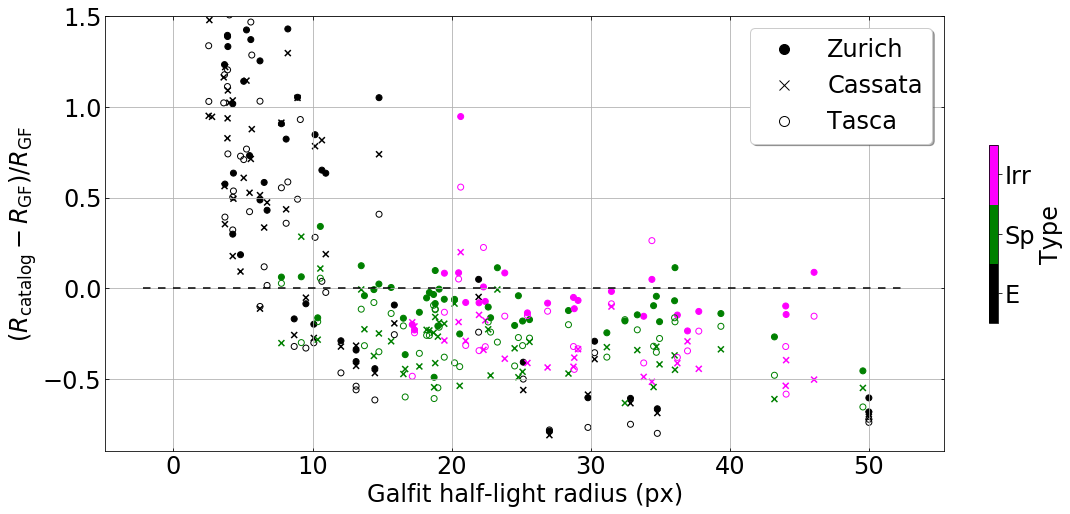

In [34]:
## Plotting the absolute difference in radii between Catalogs and GalFit radii against GalFit (in px)
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)

f   = plt.figure()
plt.subplots_adjust(wspace=0, hspace=0.1)

newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['black', 'green', 'magenta'])


#Last subplot
ax7 = f.add_subplot(111)
ax7.yaxis.set_ticks_position('both')
ax7.xaxis.set_ticks_position('both')
ax7.tick_params(which='both', direction='in', labelsize=24)
ax7.set_ylim(top=1.5, bottom=-0.9)
plt.grid()

#Plot data
plt.scatter(GFb_R, (R_half_Zurich - GFb_R)/GFb_R, label="Zurich", c=classCassata,  marker='o',
            vmin=0.5, vmax=3.5, cmap=newcmap)

plt.scatter(GFb_R, (R_half_CASSATA - GFb_R)/GFb_R, label="Cassata", c=classCassata, 
            marker='x', vmin=0.5, vmax=3.5, cmap=newcmap)

ret = plt.scatter(GFb_R, (R_half_TASCA - GFb_R)/GFb_R, label="Tasca", c=classCassata, 
                  marker='o', vmin=0.5, vmax=3.5, cmap=newcmap)
ret.set_facecolor('none')
col = plt.colorbar(ret, fraction=0.01)

ax7.scatter(GF_Ro, (R_half_Zuricho - GF_Ro)/GF_Ro, cmap=newcmap, c=classCassatao, vmin=0.5, 
        vmax=3.5, marker='o')

ax7.scatter(GF_Ro, (R_half_CASSATAo - GF_Ro)/GF_Ro, cmap=newcmap, c=classCassatao, vmin=0.5, 
        vmax=3.5, marker='x')

ret = ax7.scatter(GF_Ro, (R_half_TASCAo - GF_Ro)/GF_Ro, cmap=newcmap, c=classCassatao, vmin=0.5, 
        vmax=3.5, marker='o')
ret.set_facecolor('none')

Cassata = mlines.Line2D([], [], color='black', marker='x', markersize=10, label='Cassata', linestyle='None')
Zurich  = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Zurich', linestyle='None')
Tasca   = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Tasca', linestyle='None', fillstyle='none')
plt.legend(handles=[Zurich, Cassata, Tasca], loc='best', prop={'size': 24}, shadow=True, fancybox=True).set_zorder(1000)

col.set_ticks([1, 2, 3])
col.ax.set_yticklabels(['E', 'Sp', 'Irr'], size=24)
col.set_label("Type", size=24)

plt.xlabel("Galfit half-light radius (px)", size=24)
plt.ylabel(r"$  (R_{\rm{catalog}} - R_{\rm{GF}}) / R_{\rm{GF}}$", size=24)
print(len(classCassata==1))

ax7.plot(ax7.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

f.savefig("Plots/plotsWithColourCoding/relErr_against_GalFit1.5LightRadius_colourCoded_matchAllTypes_TwoGalFitRadii.pdf", bbox_inches='tight')


# Plotting against GalFit half-light radius (selection on the lowest GalFit radius between bulge and disk) with colour coding on galaxy type
 

In [44]:
#Remove incorrect values in GalFit radius column
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)
#Remove nan values in all arrays
mask2      = maskToRemoveVal([table['R50_ZURICH'], 
                         table['R_d_GF'], table['R_HALF_CASSATA'], 
                         table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                         table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                         table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                         table['CLASS_LINEE_TASCA'], table['TYPE_ZURICH']])
#Remove too large values in CASSATA (high probability they are wrong)
m          = table['R_HALF_CASSATA']<50
#Keep values for which the morphological classes between catalogs are the same
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA']) == table['TYPE_ZURICH']
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA'])
# classMask  = table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']
classMask  = table['AUTOCLASS_CASSATA'] == table['AUTOCLASS_CASSATA']

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(mask, mask2), m), classMask)


#Apply master mask and retrieve data
R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich = applyMask([table['R50_ZURICH'], 
                                              table['R_d_GF'], table['R_b_GF'], table['R_HALF_CASSATA'], 
                                              table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                                              table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                                              table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                                              table['CLASS_SVM_TASCA'], table['TYPE_ZURICH']], 
                                              masterMask)

#Change unit of deconvolved radius array from arcsec to pixel
R_half_Deconv  /= 0.03

#Checking everything is ok
findWhereIsValue([GF_R], val=999)
findWhereIsValue([GF_R], val=50)
findWhereIsValue([R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, 
                  classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich])

ellMask = classCassata!=1
R_half_Zuricho, GF_Ro, GFb_Ro, R_half_CASSATAo, R_half_TASCAo, R_half_Deconvo, masso, classCassatao, classTascaInto, classTascaLineeo, classTascaSVMo, classZuricho = applyMask([R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich], ellMask)
ellMask = classCassata==1
R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich = applyMask([R_half_Zurich, GF_R, GFb_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich], ellMask)

newGF_R = np.where(GF_R<GFb_R, GF_R, GFb_R)

No value 999 found within array number 0
No value 50 found within array number 0
No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No nan was found in array number 6
No nan was found in array number 7
No nan was found in array number 8
No nan was found in array number 9
No nan was found in array number 10


71


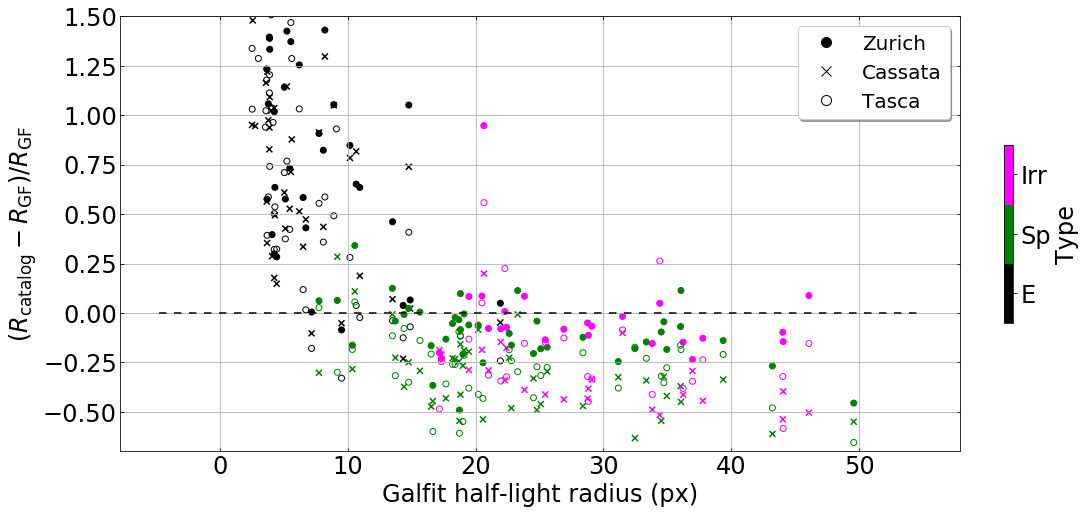

In [61]:
from stage2 import *
import matplotlib.lines as mlines

## Plotting the absolute difference in radii between Catalogs and GalFit radii against GalFit (in px)
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)

f   = plt.figure()
plt.subplots_adjust(wspace=0, hspace=0.15)

newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['black', 'green', 'magenta'])

#Last subplot
ax7 = f.add_subplot(111)
ax7.yaxis.set_ticks_position('both')
ax7.xaxis.set_ticks_position('both')
ax7.tick_params(which='both', direction='in', labelsize=24)
ax7.set_ylim(top=1.5, bottom=-0.7)
plt.grid()
ax7.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plot data
plt.scatter(newGF_R, (R_half_Zurich - newGF_R)/newGF_R, label="Zurich", c=classCassata,  marker='o',
            vmin=0.5, vmax=3.5, cmap=newcmap)

plt.scatter(newGF_R, (R_half_CASSATA - newGF_R)/newGF_R, label="Cassata", c=classCassata, 
            marker='x', vmin=0.5, vmax=3.5, cmap=newcmap)

ret = plt.scatter(newGF_R, (R_half_TASCA - newGF_R)/newGF_R, label="Tasca", c=classCassata, 
                  marker='o', vmin=0.5, vmax=3.5, cmap=newcmap)
ret.set_facecolor('none')
col = plt.colorbar(ret, fraction=0.01)

Cassata = mlines.Line2D([], [], color='black', marker='x', markersize=10, label='Cassata', linestyle='None')
Zurich  = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Zurich', linestyle='None')
Tasca   = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Tasca', linestyle='None', fillstyle='none')
plt.legend(handles=[Zurich, Cassata, Tasca], loc='best', prop={'size': 20}, shadow=True, fancybox=True).set_zorder(1000)

ax7.scatter(GF_Ro, (R_half_Zuricho - GF_Ro)/GF_Ro, cmap=newcmap, c=classCassatao, vmin=0.5, 
            vmax=3.5, marker='o')
  
ax7.scatter(GF_Ro, (R_half_CASSATAo - GF_Ro)/GF_Ro, cmap=newcmap, c=classCassatao, vmin=0.5, 
            vmax=3.5, marker='x')

ret = ax7.scatter(GF_Ro, (R_half_TASCAo - GF_Ro)/GF_Ro, cmap=newcmap, c=classCassatao, vmin=0.5, 
                  vmax=3.5, marker='o')
ret.set_facecolor('none')

col.set_ticks([1, 2, 3])
col.ax.set_yticklabels(['E', 'Sp', 'Irr'], size=24)
col.set_label("Type", size=24)

plt.xlabel("Galfit half-light radius (px)", size=24)
plt.ylabel(r"$  (R_{\rm{catalog}} - R_{\rm{GF}}) / R_{\rm{GF}}$", size=24)
print(len(classCassata==1))

#plt.savefig("Plots/plotsWithColourCoding/relErr_against_GalFit1.5LightRadius_colourCoded_matchAllTypes_keepingLowestRadiusForEllipticals.pdf", bbox_inches='tight')


### Plotting Catalogs radii against mass ###


In [37]:
#Remove incorrect values in GalFit radius column
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)
#Remove nan values in all arrays
mask2      = maskToRemoveVal([table['R50_ZURICH'], 
                         table['R_d_GF'], table['R_HALF_CASSATA'], 
                         table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                         table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                         table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                         table['CLASS_LINEE_TASCA'], table['TYPE_ZURICH']])
#Remove too large values in CASSATA (high probability they are wrong)
m          = table['R_HALF_CASSATA']<50
#Keep values for which the morphological classes between catalogs are the same
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA']) == table['TYPE_ZURICH']
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA'])
# classMask  = table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']
classMask  = table['AUTOCLASS_CASSATA'] == table['AUTOCLASS_CASSATA']

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(mask, mask2), m), 
                                           classMask)


#Apply master mask and retrieve data
R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich, mass = applyMask([table['R50_ZURICH'], 
                                              table['R_d_GF'], table['R_HALF_CASSATA'], 
                                              table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                                              table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                                              table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                                              table['CLASS_SVM_TASCA'], table['TYPE_ZURICH'], 
                                              table['MASS_BEST']],
                                              masterMask)

#Change unit of deconvolved radius array from arcsec to pixel
R_half_Deconv  /= 0.03

#Checking everything is ok
findWhereIsValue([GF_R], val=999)
findWhereIsValue([GF_R], val=50)
findWhereIsValue([R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, 
                  classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich])

msk             = mass>-20
mass3, R_half_Zurich3, R_half_CASSATA3, R_half_TASCA3, GF_R3, classCassata3 = applyMask([mass, R_half_Zurich, R_half_CASSATA, R_half_TASCA, GF_R, classCassata], msk)

No value 999 found within array number 0
No value 50 found within array number 0
No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No nan was found in array number 6
No nan was found in array number 7
No nan was found in array number 8
No nan was found in array number 9
No nan was found in array number 10


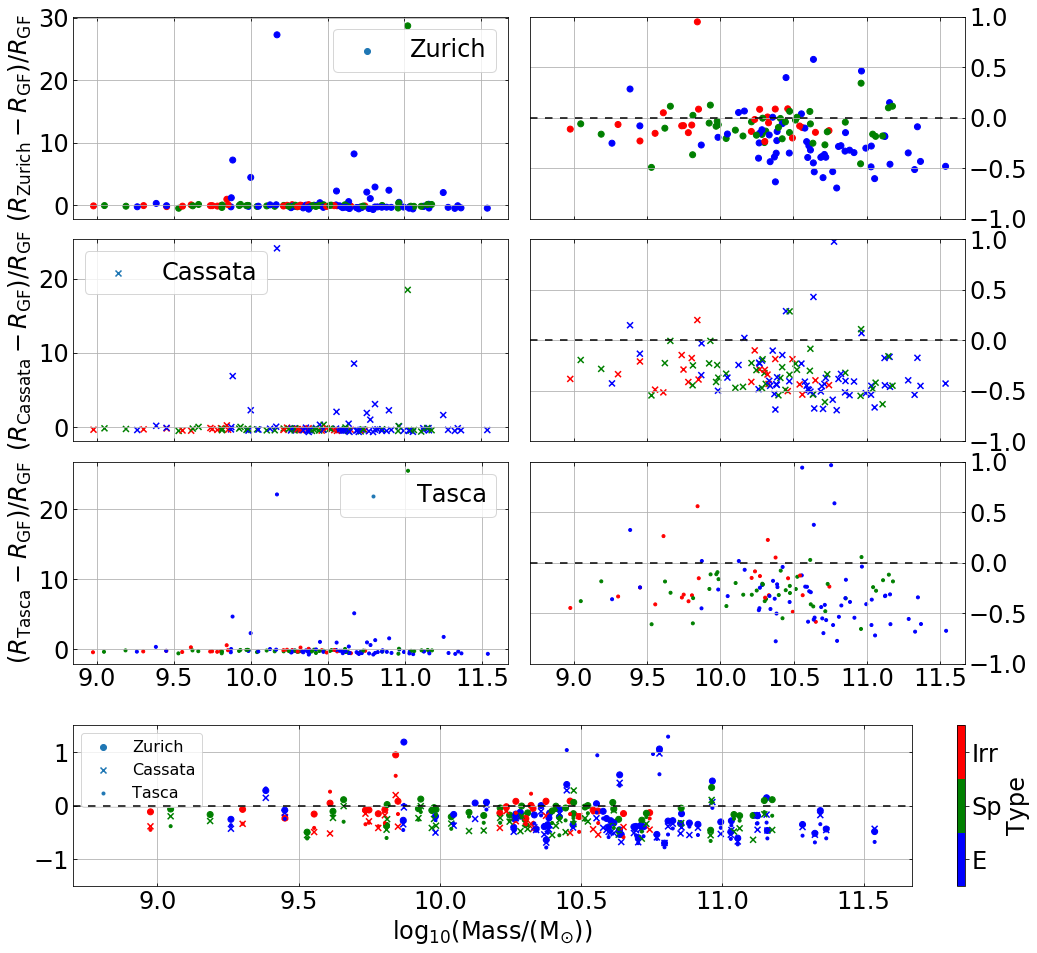

In [40]:
plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

f   = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.1)
newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['blue', 'green', 'red'])

#Plotting Zurich against GF radius
asManyPlots(421, mass3, (R_half_Zurich3 - GF_R3)/GF_R3, label='Zurich', marker='o', 
                      hideXlabel=True, ylabel=r"$(R_{\rm{Zurich}} - R_{\rm{GF}})  /R_{\rm{GF}}$", showLegend=True,
                      plotFlag=False, cmap=newcmap, legendTextSize=24,
                      color=classCassata3, cmapMin=0.5, cmapMax=3.5)

#Plotting Cassata against GF radius
asManyPlots(423, mass3, (R_half_CASSATA3 - GF_R3)/GF_R3, label='Cassata', marker='x', 
                      hideXlabel=True, ylabel=r"$(R_{\rm{Cassata}} - R_{\rm{GF}})  /R_{\rm{GF}}$", 
                      showLegend=True, plotFlag=False, cmap=newcmap, legendTextSize=24,
                      color=classCassata3, cmapMin=0.5, cmapMax=3.5, locLegend='upper left')

#Plotting Tasca against GF radius
asManyPlots(425, mass3, (R_half_TASCA3 - GF_R3)/GF_R3, label='Tasca', marker='.', 
                      ylabel=r"$(R_{\rm{Tasca}} - R_{\rm{GF}})  /R_{\rm{GF}}$", 
                      showLegend=True, plotFlag=False, cmap=newcmap, legendTextSize=24,
                      color=classCassata3, cmapMin=0.5, cmapMax=3.5)

#Plotting Zurich against GF radius
ax, tmp = asManyPlots(422, mass3, (R_half_Zurich3 - GF_R3)/GF_R3, label='Zurich', marker='o', 
                      hideXlabel=True, ylabel=r"$(R_{\rm{Zurich}} - R_{\rm{GF}})  /R_{\rm{GF}}$", 
                      plotFlag=False, cmap=newcmap, legendTextSize=24, 
                      xlim=[8.7, None], color=classCassata3, cmapMin=0.5, hideYlabel=True,
                      cmapMax=3.5, placeYaxisOnRight=True, ylim=[-1, 1])
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting Cassata against GF radius
ax, tmp = asManyPlots(424, mass3, (R_half_CASSATA3 - GF_R3)/GF_R3, label='Cassata', marker='x', 
                      hideXlabel=True, ylabel=r"$(R_{\rm{Cassata}} - R_{\rm{GF}})  /R_{\rm{GF}}$", 
                      plotFlag=False, cmap=newcmap, legendTextSize=24, hideYlabel=True,
                      color=classCassata3, cmapMin=0.5, cmapMax=3.5, xlim=[8.7, None],
                      placeYaxisOnRight=True, ylim=[-1, 1])
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting Tasca against GF radius
ax, tmp = asManyPlots(426, mass3, (R_half_TASCA3 - GF_R3)/GF_R3, label='Tasca', marker='.', 
                      ylabel=r"$(R_{\rm{Tasca}} - R_{\rm{GF}})  /R_{\rm{GF}}$", 
                      plotFlag=False, cmap=newcmap, legendTextSize=24, hideYlabel=True,
                      color=classCassata3, cmapMin=0.5, cmapMax=3.5, xlim=[8.7, None],
                      placeYaxisOnRight=True, ylim=[-1, 1])
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting everything against GF radius
ax, tmp = asManyPlots(515, mass3, (R_half_Zurich3 - GF_R3)/GF_R3, label='Zurich', marker='o', 
                      ylabel=r"$(R_{\rm{Catalog}} - R_{\rm{GF}})  /R_{\rm{GF}}$",
                      plotFlag=False, cmap=newcmap, legendTextSize=24, color=classCassata3, 
                      cmapMin=0.5, cmapMax=3.5, xlabel=r'$\log_{10} (\rm{Mass}/(M_{\odot}))$', 
                      xlim=[8.7, None], ylim=[-1.5, 1.5], hideYlabel=True)
ax.scatter(mass3, (R_half_CASSATA3 - GF_R3)/GF_R3, c=classCassata3, cmap=newcmap, label="Cassata", marker='x')
ax.scatter(mass3, (R_half_TASCA3 - GF_R3)/GF_R3, c=classCassata3, cmap=newcmap, label="Tasca", marker='.')
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
col = plt.colorbar(tmp, fraction=0.01)
col.set_ticks([1, 2, 3])
col.ax.set_yticklabels(['E', 'Sp', 'Irr'], size=24)
col.set_label("Type", size=24)
plt.legend(loc='upper left', prop={'size': 16})

# f.savefig("Plots/plotsWithColourCoding/relErr_against_mass_colourCodedWithCassataType.pdf", bbox_inches='tight')


### Comparing magnitudes between GalFit and catalogs ###


In [10]:
## Comparing different magnitudes

magGF      = table["Mag_d_GF"]
magbGF     = table['Mag_b_GF']
magTasca   = table['ACS_MAG_AUTO_TASCA']
magCassata = table['MAG_AUTO_ACS_CASSATA'] 
magZurich  = table['ACS_MAG_AUTO_ZURICH']

magTot     = -2.5*np.log10(10**(-magGF/2.5)+10**(-magbGF/2.5))
print(np.shape(magTot))

(279,)


/home/wilfried/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:6667: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [11]:
#Constructing and applying relevant masks
m = maskToRemoveVal([magGF, magTasca, magCassata, magZurich, magbGF], val=-999, keep=False)
magGF, magbGF, magTasca, magCassata, magZurich, magTot = applyMask([magGF, magbGF, magTasca, 
                                                                    magCassata, magZurich,
                                                                    magTot], m)
#Checking the masks did their job
findWhereIsValue([magGF, magTasca, magCassata, magZurich, magTot], -999)

No value -999 found within array number 0
No value -999 found within array number 1
No value -999 found within array number 2
No value -999 found within array number 3
No value -999 found within array number 4


Text(0.5, 0, '$\\rm{GalFit\\,\\, disk+bulb\\,\\, magnitude\\,\\, (mag)}$')

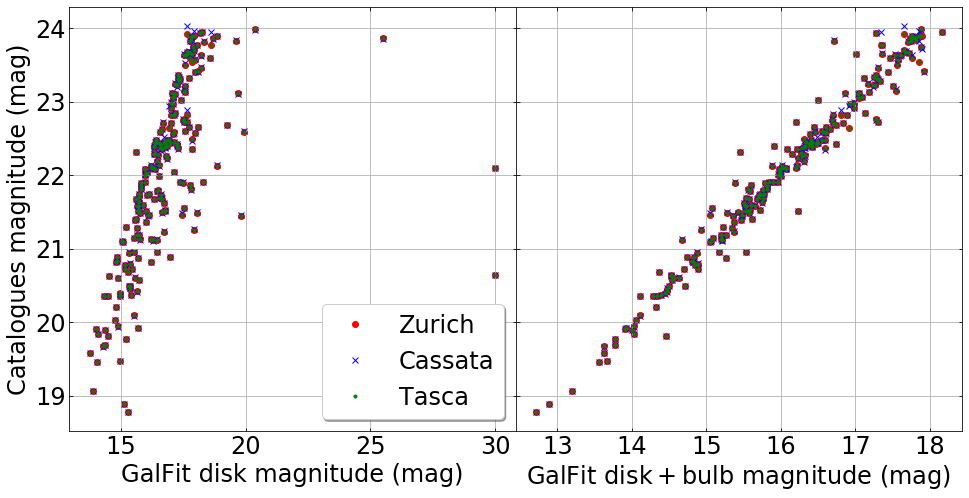

In [23]:
## Plotting Catalogs magnitudes against GalFit one

plt.rcParams["figure.figsize"] = (16, 16) # (w, h)

#Same as before but with the same scale
#Plotting Zurich against GF radius
f   = plt.figure()
plt.subplots_adjust(wspace=0, hspace=0.05)
ax4 = f.add_subplot(221)
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
ax4.tick_params(which='both', direction='in', labelsize=24)
plt.grid()

#Plot data
plt.plot(magGF, magZurich, "ro", label="Zurich", zorder=1)
plt.plot(magGF, magCassata, "bx", label="Cassata", zorder=2)
plt.plot(magGF, magTasca, "g.", label="Tasca", zorder=3)

plt.xlabel("GalFit disk magnitude (mag)", size=24)
plt.ylabel("Catalogues magnitude (mag)", size=24)
plt.legend(loc='lower right', prop={'size': 24}, shadow=True, fancybox=True, ncol=1)

ax1 = f.add_subplot(222)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(which='both', direction='in', labelsize=24)
ax1.axes.get_yaxis().set_ticklabels([])
plt.grid()

#Plot data
plt.plot(magTot, magZurich, "ro", label="Zurich", zorder=1)
plt.plot(magTot, magCassata, "bx", label="Cassata", zorder=2)
plt.plot(magTot, magTasca, "g.", label="Tasca", zorder=3)

plt.xlabel(r"$\rm{GalFit\,\, disk+bulb\,\, magnitude\,\, (mag)}$", size=24)

#f.savefig("Plots/catalogMag_against_GalfitMag_corrected.pdf", bbox_inches='tight')

In [182]:
a = np.array([0,1,2])
10**(a)

array([  1,  10, 100])


### Comparing GalFit radius against magnitudes ###


In [41]:
## Computing total GalFit magnitude (bulb+disk)
magTot     = -2.5*np.log10(10**(-table["Mag_d_GF"]/2.5)+10**(-table['Mag_b_GF']/2.5))

/home/wilfried/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:6667: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [42]:
#Remove incorrect values in GalFit radius column
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)

#Remove nan values in all arrays
mask2      = maskToRemoveVal([table['R50_ZURICH'], 
                         table['R_d_GF'], table['R_HALF_CASSATA'], 
                         table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                         table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                         table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                         table['CLASS_LINEE_TASCA'], table['TYPE_ZURICH'],
                         table["Mag_d_GF"], table['MAG_AUTO_ACS_CASSATA'],
                         table['Mag_b_GF']])

#Remove too large values in CASSATA (high probability they are wrong)
m          = table['R_HALF_CASSATA']<50

#Keep values for which the morphological classes between catalogs are the same
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA']) == table['TYPE_ZURICH']
# classMask  = ((table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']) == table['CLASS_LINEE_TASCA'])
# classMask  = table['AUTOCLASS_CASSATA'] == table['CLASS_INT_TASCA']
classMask  = table['AUTOCLASS_CASSATA'] == table['AUTOCLASS_CASSATA']

#Mask for magnitudes
m2 = maskToRemoveVal([table["Mag_d_GF"], table['MAG_AUTO_ACS_CASSATA'],
                      table['Mag_b_GF']], val=-999, keep=False)

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(mask, mask2), m), classMask), m2)

#Apply master mask and retrieve data
R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich, magTot, magCassata = applyMask([table['R50_ZURICH'], 
                                              table['R_d_GF'], table['R_HALF_CASSATA'], 
                                              table['R_HALF_TASCA'], table['R_0P5_GIM2D_ZURICH'], 
                                              table['MASS_BEST'], table['AUTOCLASS_CASSATA'], 
                                              table['CLASS_INT_TASCA'], table['CLASS_LINEE_TASCA'], 
                                              table['CLASS_SVM_TASCA'], table['TYPE_ZURICH'], 
                                              magTot, table['MAG_AUTO_ACS_CASSATA']],
                                              masterMask)

#Change unit of deconvolved radius array from arcsec to pixel
R_half_Deconv  /= 0.03

#Checking everything is ok
findWhereIsValue([GF_R], val=999)
findWhereIsValue([GF_R], val=50)
findWhereIsValue([R_half_Zurich, GF_R, R_half_CASSATA, R_half_TASCA, R_half_Deconv, mass, 
                  classCassata, classTascaInt, classTascaLinee, classTascaSVM, classZurich])
findWhereIsValue([magTot, magCassata], -999)

No value 999 found within array number 0
No value 50 found within array number 0
No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No nan was found in array number 6
No nan was found in array number 7
No nan was found in array number 8
No nan was found in array number 9
No nan was found in array number 10
No value -999 found within array number 0
No value -999 found within array number 1


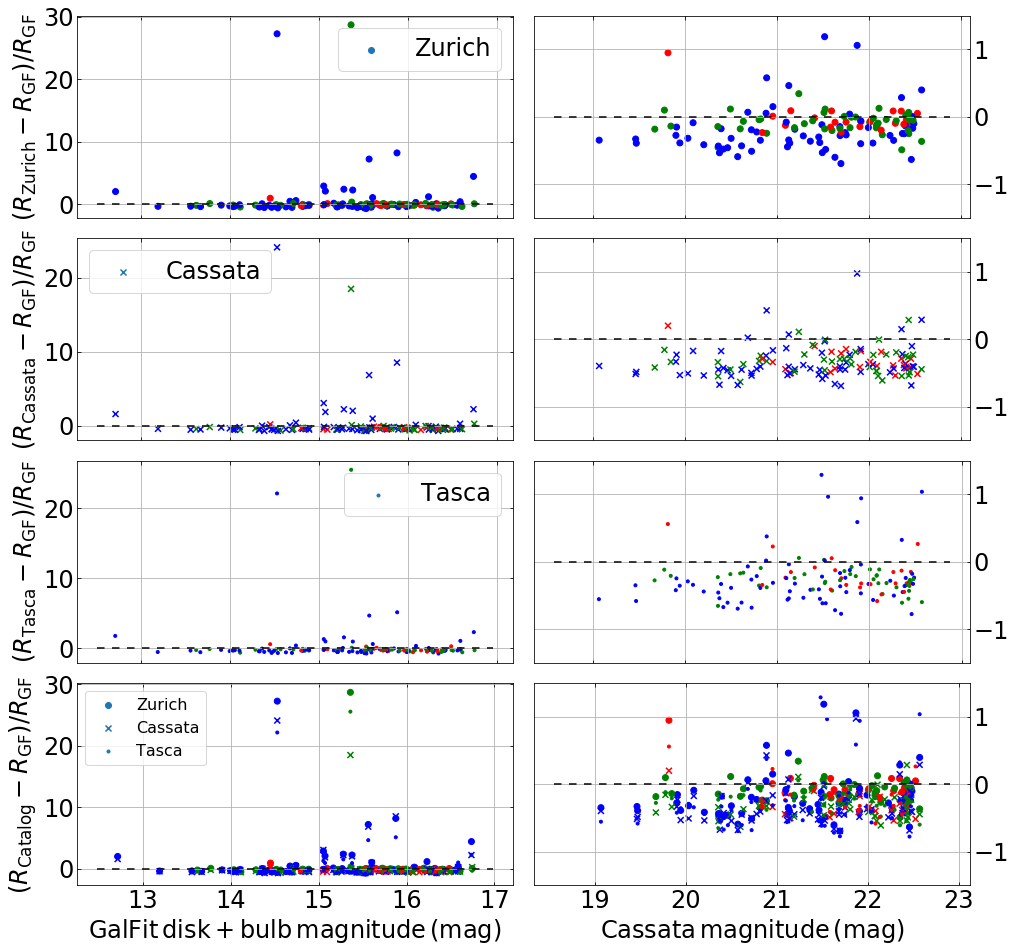

In [49]:
## Plotting absolute difference in radii between catalogs and GalFit against magnitude

plt.rcParams["figure.figsize"] = (16, 16)

#Plotting Zurich against GF radius
f = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

#Plotting Zurich against GF radius
ax, tmp = asManyPlots(421, magTot, (R_half_Zurich - GF_R)/GF_R, label='Zurich', marker='o', 
            hideXlabel=True, ylabel=r"$(R_{\rm{Zurich}} - R_{\rm{GF}})  /R_{\rm{GF}}$", showLegend=True,
            plotFlag=False, cmap=newcmap, legendTextSize=24,
            color=classCassata, cmapMin=0.5, cmapMax=3.5)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting Cassata against GF radius
ax, tmp = asManyPlots(423, magTot, (R_half_CASSATA - GF_R)/GF_R, label='Cassata', marker='x', 
            hideXlabel=True, ylabel=r"$(R_{\rm{Cassata}} - R_{\rm{GF}})  /R_{\rm{GF}}$", 
            showLegend=True, plotFlag=False, cmap=newcmap, legendTextSize=24,
            color=classCassata, cmapMin=0.5, cmapMax=3.5, locLegend='upper left')
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting Tasca against GF radius
ax, tmp = asManyPlots(425, magTot, (R_half_TASCA - GF_R)/GF_R, label='Tasca', marker='.', 
            ylabel=r"$(R_{\rm{Tasca}} - R_{\rm{GF}})  /R_{\rm{GF}}$", 
            showLegend=True, plotFlag=False, cmap=newcmap, legendTextSize=24,
            color=classCassata, cmapMin=0.5, cmapMax=3.5, hideXlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting everything against GF radius
ax, tmp = asManyPlots(427, magTot, (R_half_Zurich - GF_R)/GF_R, label='Zurich', marker='o', 
                      ylabel=r"$(R_{\rm{Catalog}} - R_{\rm{GF}})  /R_{\rm{GF}}$",
                      plotFlag=False, cmap=newcmap, legendTextSize=24, color=classCassata, 
                      cmapMin=0.5, cmapMax=3.5, xlabel=r"$\rm{GalFit \, disk+bulb \, magnitude \, (mag)}$")
ax.scatter(magTot, (R_half_CASSATA - GF_R)/GF_R, c=classCassata, cmap=newcmap, label="Cassata", marker='x')
ax.scatter(magTot, (R_half_TASCA - GF_R)/GF_R, c=classCassata, cmap=newcmap, label="Tasca", marker='.')
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
plt.legend(loc='upper left', prop={'size': 16})



#Plotting Zurich against GF radius
ax, tmp = asManyPlots(422, magCassata, (R_half_Zurich - GF_R)/GF_R, label='Zurich', marker='o', 
                      hideXlabel=True, ylabel=r"$(R_{\rm{Zurich}} - R_{\rm{GF}})  /R_{\rm{GF}}$", 
                      plotFlag=False, cmap=newcmap, legendTextSize=24, 
                      color=classCassata, cmapMin=0.5, hideYlabel=True,
                      cmapMax=3.5, placeYaxisOnRight=True, ylim=[-1.5, 1.5])
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting Cassata against GF radius
ax, tmp = asManyPlots(424, magCassata, (R_half_CASSATA - GF_R)/GF_R, label='Cassata', marker='x', 
                      hideXlabel=True, ylabel=r"$(R_{\rm{Cassata}} - R_{\rm{GF}})  /R_{\rm{GF}}$", 
                      plotFlag=False, cmap=newcmap, legendTextSize=24, hideYlabel=True,
                      color=classCassata, cmapMin=0.5, cmapMax=3.5,
                      placeYaxisOnRight=True, ylim=[-1.5, 1.5])
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting Tasca against GF radius
ax, tmp = asManyPlots(426, magCassata, (R_half_TASCA - GF_R)/GF_R, label='Tasca', marker='.', 
                      ylabel=r"$(R_{\rm{Tasca}} - R_{\rm{GF}})  /R_{\rm{GF}}$", 
                      plotFlag=False, cmap=newcmap, legendTextSize=24, hideYlabel=True,
                      color=classCassata, cmapMin=0.5, cmapMax=3.5,
                      placeYaxisOnRight=True, ylim=[-1.5, 1.5], hideXlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Plotting everything against GF radius
ax, tmp = asManyPlots(428, magCassata, (R_half_Zurich - GF_R)/GF_R, label='Zurich', marker='o', 
                      ylabel=r"$(R_{\rm{Catalog}} - R_{\rm{GF}})  /R_{\rm{GF}}$",
                      plotFlag=False, cmap=newcmap, legendTextSize=24, color=classCassata, 
                      cmapMin=0.5, cmapMax=3.5, xlabel=r"$\rm{Cassata \, magnitude \, (mag)}$", 
                      ylim=[-1.5, 1.5], hideYlabel=True, placeYaxisOnRight=True)
ax.scatter(magCassata, (R_half_CASSATA - GF_R)/GF_R, c=classCassata, cmap=newcmap, label="Cassata", marker='x')
ax.scatter(magCassata, (R_half_TASCA - GF_R)/GF_R, c=classCassata, cmap=newcmap, label="Tasca", marker='.')
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

# f.savefig("Plots/plotsWithColourCoding/relErr_against_mag_colourCodedWithCassataType.pdf", bbox_inches='tight')

In [219]:

### Comparison between b/a within different catalogs ###


In [9]:
#Remove nan values
m = maskToRemoveVal([table['b_a_d_GF'], table['b_a_b_GF'], table['Axial_Ratio_TASCA'], table['Axial_Ratio_CASSATA'], table['ACS_ELONGATION_ZURICH'], table['ELL_GIM2D_ZURICH']])

#Remove a/b=0 values
m2 = maskToRemoveVal([table['ACS_ELONGATION_ZURICH']], val=0, keep=False)

#Remove -999 values in GalFit b/a
m3 = table['b_a_d_GF']!=-999

#Build master mask
masterMask = np.logical_and(np.logical_and(m, m2), m3)

#Apply master mask
b_a_d_GF, b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D, ellFlagGIM2D, classCassata = applyMask([table['b_a_d_GF'], 
                                          table['b_a_b_GF'], table['Axial_Ratio_TASCA'], table['Axial_Ratio_CASSATA'], 
                                          table['ACS_ELONGATION_ZURICH'], table['ELL_GIM2D_ZURICH'], table['ELLI_ZURICH'],
                                          table['AUTOCLASS_CASSATA']], masterMask)

#Checking the masks worked
findWhereIsValue([b_a_d_GF, b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D])
findWhereIsValue([a_bZurichSextractor], val=0)
findWhereIsValue([b_a_d_GF], val=-999)                  

#Computing b/a from a/b and ellipticity
b_a_ZurichSextractor  = 1.0/a_bZurichSextractor
b_aGIM2D              = 1.0-ellZurichGIM2D

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No value 0 found within array number 0
No value -999 found within array number 0


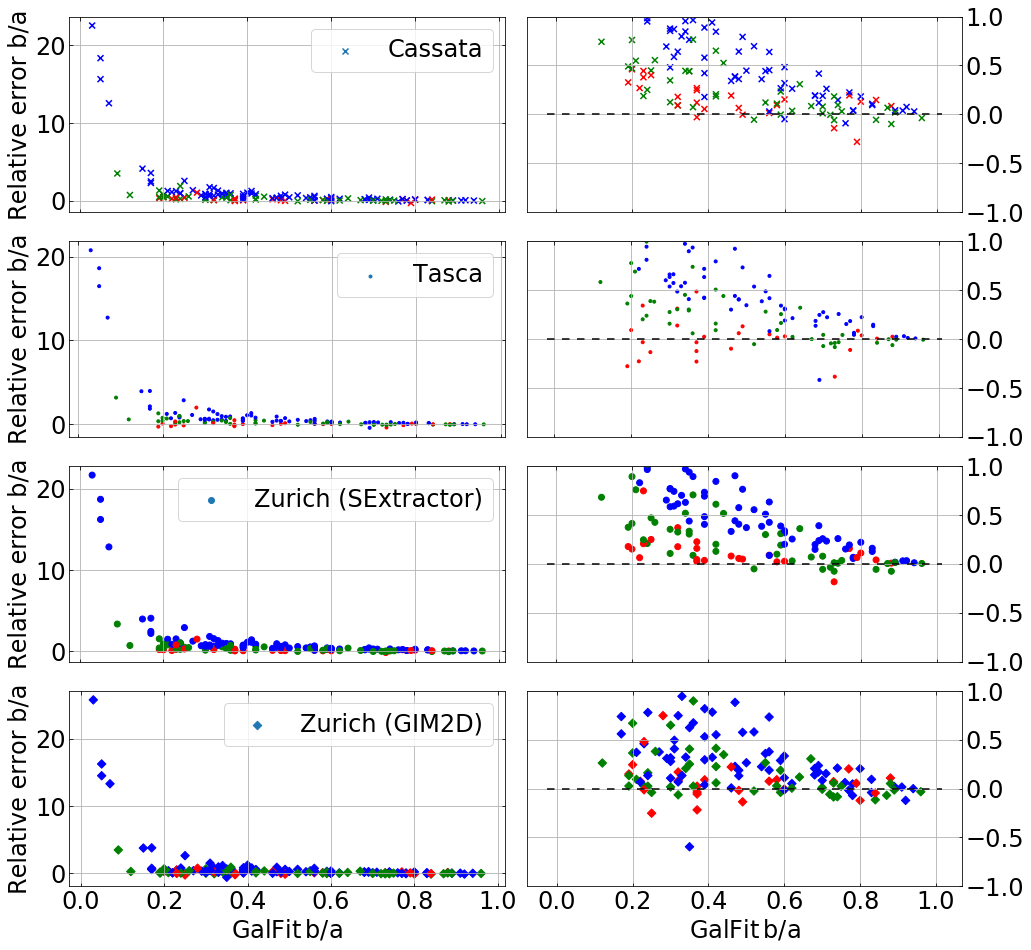

In [16]:
## Plotting a/b from different catalogs

plt.rcParams["figure.figsize"] = (16, 16)
f = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.15)
newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['blue', 'green', 'red'])

#Cassata b/a plot
asManyPlots(421, b_a_d_GF, (b_aCassata-b_a_d_GF)/b_a_d_GF, label="Cassata", hideXlabel=True, 
            ylabel="Relative error b/a",
            color=classCassata, cmap=newcmap, plotFlag=False, showLegend=True, marker='x')

#Tasca b/a plot
asManyPlots(423, b_a_d_GF, (b_aTasca-b_a_d_GF)/b_a_d_GF, label="Tasca", hideXlabel=True, 
            ylabel="Relative error b/a", color=classCassata, cmap=newcmap, plotFlag=False, 
            showLegend=True, marker='.')

#Zurich SExtractor plot
asManyPlots(425, b_a_d_GF, (b_a_ZurichSextractor-b_a_d_GF)/b_a_d_GF, label="Zurich (SExtractor)", 
            hideXlabel=True, ylabel="Relative error b/a", 
            color=classCassata, cmap=newcmap, plotFlag=False, showLegend=True, marker='o')

#Zurich GIM2D plot
asManyPlots(427, b_a_d_GF, (b_aGIM2D-b_a_d_GF)/b_a_d_GF, label="Zurich (GIM2D)", marker='D',
            xlabel=r"$\rm{GalFit \, b/a}$", ylabel="Relative error b/a", 
            color=classCassata, cmap=newcmap, plotFlag=False, showLegend=True)



#Cassata b/a plot
ax, tmp = asManyPlots(422, b_a_d_GF, (b_aCassata-b_a_d_GF)/b_a_d_GF, label="Cassata", hideXlabel=True, 
            ylabel="Relative error b/a",
            color=classCassata, cmap=newcmap, plotFlag=False, marker='x',
            ylim=[-1, 1], placeYaxisOnRight=True, hideYlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Tasca b/a plot
ax, tmp = asManyPlots(424, b_a_d_GF, (b_aTasca-b_a_d_GF)/b_a_d_GF, label="Tasca", hideXlabel=True, 
            ylabel="Relative error b/a", color=classCassata, cmap=newcmap, plotFlag=False, 
            marker='.', ylim=[-1, 1], placeYaxisOnRight=True, hideYlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Zurich SExtractor plot
ax, tmp = asManyPlots(426, b_a_d_GF, (b_a_ZurichSextractor-b_a_d_GF)/b_a_d_GF, label="Zurich (SExtractor)", 
            hideXlabel=True, ylabel="Relative error b/a", 
            color=classCassata, cmap=newcmap, plotFlag=False, marker='o',
            ylim=[-1, 1], hideYlabel=True, placeYaxisOnRight=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Zurich GIM2D plot
ax, tmp = asManyPlots(428, b_a_d_GF, (b_aGIM2D-b_a_d_GF)/b_a_d_GF, label="Zurich (GIM2D)", marker='D',
            xlabel=r"$\rm{GalFit \, b/a}$", ylabel="Relative error b/a", 
            color=classCassata, cmap=newcmap, plotFlag=False,
            ylim=[-1, 1], placeYaxisOnRight=True, hideYlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

# f.savefig("Plots/plotsWithColourCoding/relErr_b_a_against_GalFit_b_a_CassataColourCoded.pdf", bbox_inches='tight')

In [219]:

### Comparison between b/a within different catalogs against GalFit disk radius ###


In [17]:
#Remove wrong values of GalFit radius
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)

#Remove nan values
m = maskToRemoveVal([table['b_a_d_GF'], table['b_a_b_GF'], table['Axial_Ratio_TASCA'], table['Axial_Ratio_CASSATA'], table['ACS_ELONGATION_ZURICH'], table['ELL_GIM2D_ZURICH'], table['R_d_GF']])

#Remove a/b=0 values
m2 = maskToRemoveVal([table['ACS_ELONGATION_ZURICH']], val=0, keep=False)

#Remove -999 values in GalFit b/a
m3 = table['b_a_d_GF']!=-999

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(m, m2), m3), mask)

#Apply master mask
GF_R, b_a_d_GF, b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D, ellFlagGIM2D, classCassata = applyMask([table['R_d_GF'], 
                                          table['b_a_d_GF'], 
                                          table['b_a_b_GF'], table['Axial_Ratio_TASCA'], table['Axial_Ratio_CASSATA'], 
                                          table['ACS_ELONGATION_ZURICH'], table['ELL_GIM2D_ZURICH'], table['ELLI_ZURICH'],
                                          table['AUTOCLASS_CASSATA']], masterMask)

#Checking the masks worked
findWhereIsValue([b_a_d_GF, b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D])
findWhereIsValue([a_bZurichSextractor], val=0)
findWhereIsValue([b_a_d_GF, GF_R], val=-999)
findWhereIsValue([GF_R], val=50)

#Split between elliptical and spiral/irregular galaxies
# ellMask = classCassata!=1
# b_a_d_GFo, b_a_b_GFo, b_aTascao, b_aCassatao, a_bZurichSextractoro, ellZurichGIM2Do, ellFlagGIM2Do, classCassatao = applyMask([b_a_d_GF, 
#                                                                     b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D, 
#                                                                     ellFlagGIM2D, classCassata], ellMask)
# ellMask = classCassata==1
# b_a_d_GF, b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D, ellFlagGIM2D, classCassata = applyMask([b_a_d_GF, 
#                                                                b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D, 
#                                                                ellFlagGIM2D, classCassata], ellMask)

#Computing b/a from a/b and ellipticity
b_a_ZurichSextractor  = 1.0/a_bZurichSextractor
# b_a_ZurichSextractoro = 1.0/a_bZurichSextractoro
b_aGIM2D              = 1.0-ellZurichGIM2D
# b_aGIM2Do             = 1.0-ellZurichGIM2Do

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No value 0 found within array number 0
No value -999 found within array number 0
No value -999 found within array number 1
No value 50 found within array number 0


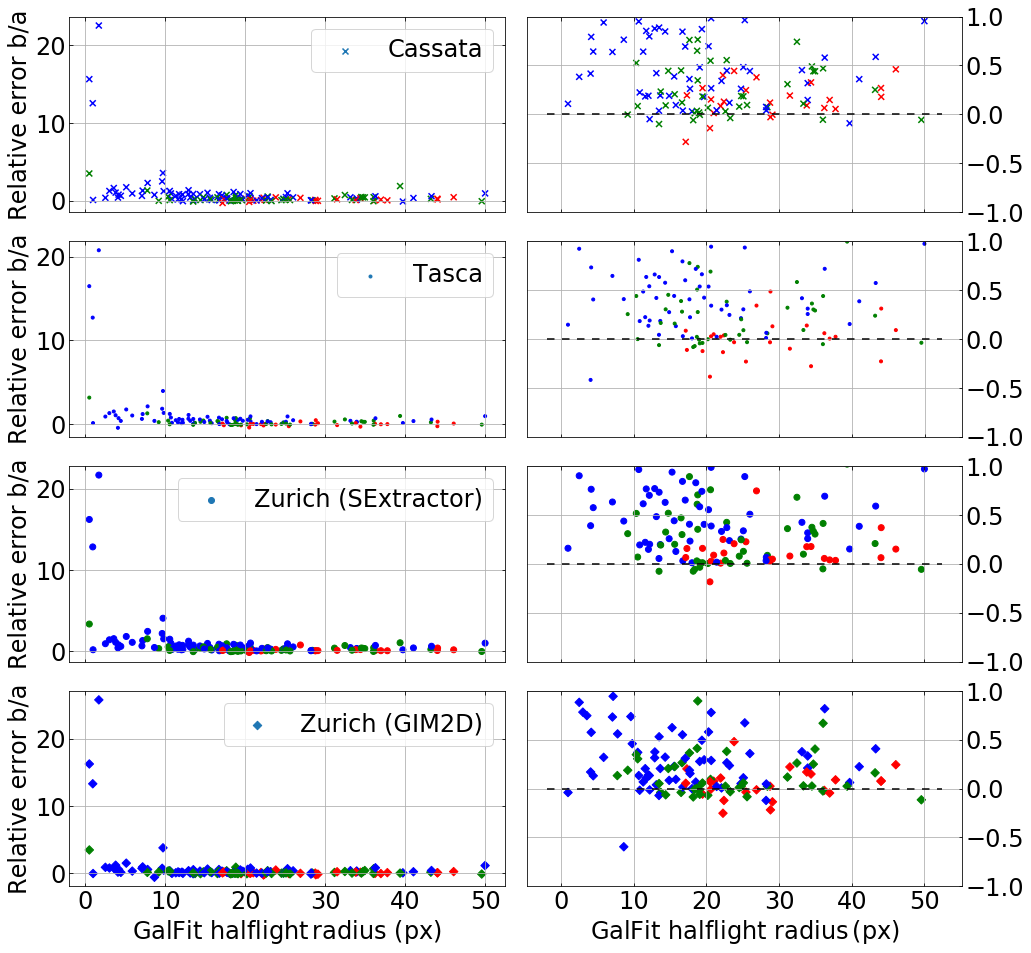

In [20]:
## Plotting a/b from different catalogs

plt.rcParams["figure.figsize"] = (16, 16)
f = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.15)
newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['blue', 'green', 'red'])

#Cassata b/a plot
asManyPlots(421, GF_R, (b_aCassata-b_a_d_GF)/b_a_d_GF, label="Cassata", hideXlabel=True, 
            ylabel="Relative error b/a",
            color=classCassata, cmap=newcmap, plotFlag=False, showLegend=True, marker='x')

#Tasca b/a plot
asManyPlots(423, GF_R, (b_aTasca-b_a_d_GF)/b_a_d_GF, label="Tasca", hideXlabel=True, 
            ylabel="Relative error b/a", color=classCassata, cmap=newcmap, plotFlag=False, 
            showLegend=True, marker='.')

#Zurich SExtractor plot
asManyPlots(425, GF_R, (b_a_ZurichSextractor-b_a_d_GF)/b_a_d_GF, label="Zurich (SExtractor)", 
            hideXlabel=True, ylabel="Relative error b/a", 
            color=classCassata, cmap=newcmap, plotFlag=False, showLegend=True, marker='o')

#Zurich GIM2D plot
asManyPlots(427, GF_R, (b_aGIM2D-b_a_d_GF)/b_a_d_GF, label="Zurich (GIM2D)", marker='D',
            xlabel=r"$\rm{GalFit \,\, halflight \, radius \,\, (px)}$", 
            ylabel="Relative error b/a",
            color=classCassata, cmap=newcmap, plotFlag=False, showLegend=True)



#Cassata b/a plot
ax, tmp = asManyPlots(422, GF_R, (b_aCassata-b_a_d_GF)/b_a_d_GF, label="Cassata", hideXlabel=True, 
                      ylabel="Relative error b/a",
                      color=classCassata, cmap=newcmap, plotFlag=False, marker='x',
                      ylim=[-1, 1], placeYaxisOnRight=True, hideYlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Tasca b/a plot
ax, tmp = asManyPlots(424, GF_R, (b_aTasca-b_a_d_GF)/b_a_d_GF, label="Tasca", hideXlabel=True, 
                      ylabel="Relative error b/a", 
                      color=classCassata, cmap=newcmap, plotFlag=False, 
                      marker='.', ylim=[-1, 1], placeYaxisOnRight=True, hideYlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Zurich SExtractor plot
ax, tmp = asManyPlots(426, GF_R, (b_a_ZurichSextractor-b_a_d_GF)/b_a_d_GF, label="Zurich (SExtractor)", 
                      hideXlabel=True, ylabel="Relative error b/a", 
                      color=classCassata, cmap=newcmap, plotFlag=False, marker='o',
                      ylim=[-1, 1], hideYlabel=True, placeYaxisOnRight=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

#Zurich GIM2D plot
ax, tmp = asManyPlots(428, GF_R, (b_aGIM2D-b_a_d_GF)/b_a_d_GF, label="Zurich (GIM2D)", marker='D',
                      xlabel=r"$\rm{GalFit \,\, halflight \,\, radius \, (px)}$", 
                      ylabel="Relative error b/a", 
                      color=classCassata, cmap=newcmap, plotFlag=False,
                      ylim=[-1, 1], placeYaxisOnRight=True, hideYlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)

# f.savefig("Plots/plotsWithColourCoding/relErr_b_a_against_GalFitRadius_CassataColourCoded.pdf", bbox_inches='tight')

In [219]:

### Comparison between b/a within different catalogs against radius relative error ###


In [96]:
#Remove wrong values of GalFit radius
mask       = np.logical_and(np.abs(table['R_d_GF'])<50, np.abs(table['R_d_GF'])!=999)

#Remove nan values
m = maskToRemoveVal([table['b_a_d_GF'], table['b_a_b_GF'], table['Axial_Ratio_TASCA'], table['Axial_Ratio_CASSATA'], table['ACS_ELONGATION_ZURICH'], table['ELL_GIM2D_ZURICH'], table['R50_ZURICH'], table['R_HALF_CASSATA'], table['R_HALF_TASCA'], table['R_d_GF']])

#Remove a/b=0 values
m2 = maskToRemoveVal([table['ACS_ELONGATION_ZURICH']], val=0, keep=False)

#Remove -999 values in GalFit b/a
m3 = table['b_a_d_GF']!=-999

#Remove wrong value of cassata radius
m4 = table['R_HALF_CASSATA']<50

#Build master mask
masterMask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(m, m2), m3), mask), m4)

#Apply master mask
R_half_Zurich, R_half_CASSATA, R_half_TASCA, GF_R, b_a_d_GF, b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D, ellFlagGIM2D, classCassata = applyMask([table['R50_ZURICH'], 
                                          table['R_HALF_CASSATA'], table['R_HALF_TASCA'], table['R_d_GF'], 
                                          table['b_a_d_GF'], 
                                          table['b_a_b_GF'], table['Axial_Ratio_TASCA'], table['Axial_Ratio_CASSATA'], 
                                          table['ACS_ELONGATION_ZURICH'], table['ELL_GIM2D_ZURICH'], table['ELLI_ZURICH'],
                                          table['AUTOCLASS_CASSATA']], masterMask)

#Checking the masks worked
findWhereIsValue([b_a_d_GF, b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D])
findWhereIsValue([a_bZurichSextractor], val=0)
findWhereIsValue([b_a_d_GF, GF_R], val=-999)
findWhereIsValue([GF_R, R_half_CASSATA], val=50)

#Split between elliptical and spiral/irregular galaxies
# ellMask = classCassata!=1
# b_a_d_GFo, b_a_b_GFo, b_aTascao, b_aCassatao, a_bZurichSextractoro, ellZurichGIM2Do, ellFlagGIM2Do, classCassatao = applyMask([b_a_d_GF, 
#                                                                     b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D, 
#                                                                     ellFlagGIM2D, classCassata], ellMask)
# ellMask = classCassata==1
# b_a_d_GF, b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D, ellFlagGIM2D, classCassata = applyMask([b_a_d_GF, 
#                                                                b_a_b_GF, b_aTasca, b_aCassata, a_bZurichSextractor, ellZurichGIM2D, 
#                                                                ellFlagGIM2D, classCassata], ellMask)

#Computing b/a from a/b and ellipticity
b_a_ZurichSextractor  = 1.0/a_bZurichSextractor
# b_a_ZurichSextractoro = 1.0/a_bZurichSextractoro
b_aGIM2D              = 1.0-ellZurichGIM2D
# b_aGIM2Do             = 1.0-ellZurichGIM2Do

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 5
No value 0 found within array number 0
No value -999 found within array number 0
No value -999 found within array number 1
No value 50 found within array number 0
No value 50 found within array number 1


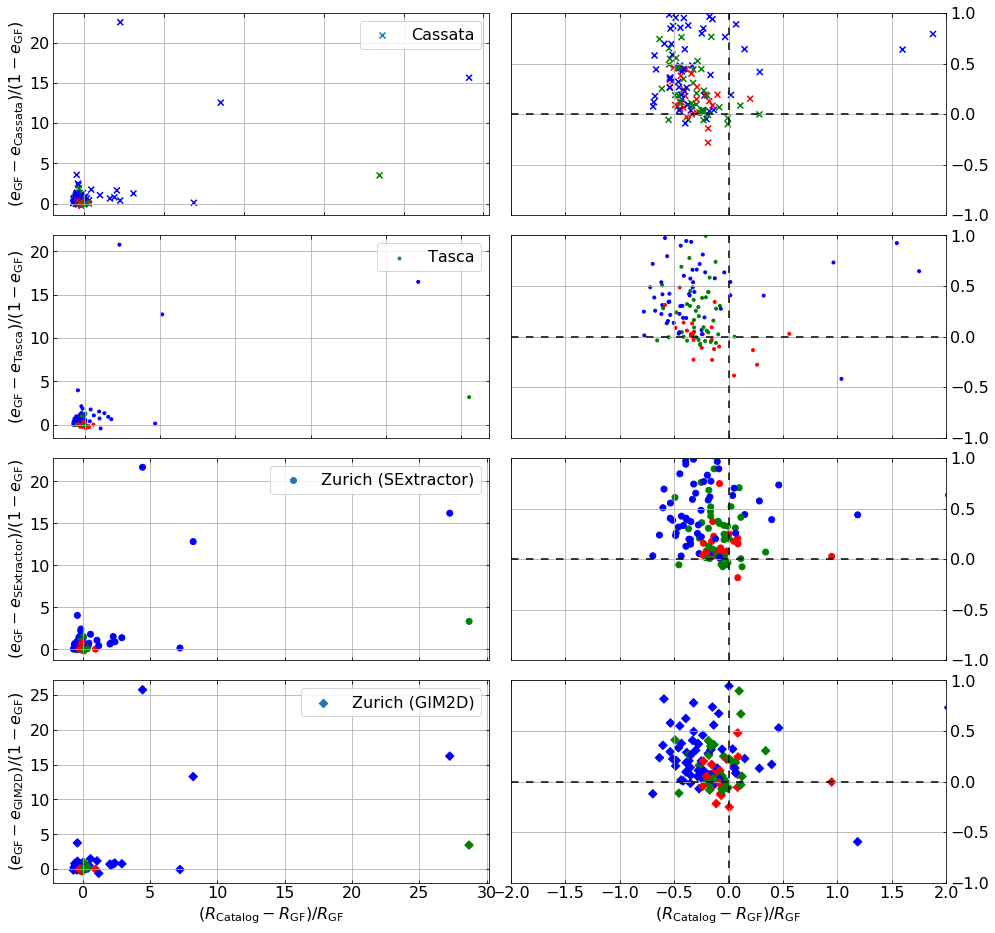

In [103]:
## Plotting a/b from different catalogs

plt.rcParams["figure.figsize"] = (16, 16)
f = plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

#Cassata b/a plot
asManyPlots(421, (R_half_CASSATA-GF_R)/GF_R, (b_aCassata-b_a_d_GF)/b_a_d_GF, 
            label="Cassata", hideXlabel=True, 
            ylabel=r"$(e_{\rm{GF}} - e_{\rm{Cassata}})/(1-e_{\rm{GF}})}$",
            color=classCassata, cmap=newcmap, plotFlag=False, showLegend=True, marker='x')

#Tasca b/a plot
asManyPlots(423, (R_half_TASCA-GF_R)/GF_R, (b_aTasca-b_a_d_GF)/b_a_d_GF, label="Tasca", hideXlabel=True, 
            ylabel=r"$(e_{\rm{GF}} - e_{\rm{Tasca}})/(1-e_{\rm{GF}})}$", color=classCassata, 
            cmap=newcmap, plotFlag=False, showLegend=True, marker='.')

#Zurich SExtractor plot
asManyPlots(425, (R_half_Zurich-GF_R)/GF_R, (b_a_ZurichSextractor-b_a_d_GF)/b_a_d_GF, 
            label="Zurich (SExtractor)", 
            hideXlabel=True, ylabel=r"$(e_{\rm{GF}} - e_{\rm{SExtractor}})/(1-e_{\rm{GF}})}$", 
            color=classCassata, cmap=newcmap, plotFlag=False, showLegend=True, marker='o')

#Zurich GIM2D plot
asManyPlots(427, (R_half_Zurich-GF_R)/GF_R, (b_aGIM2D-b_a_d_GF)/b_a_d_GF, label="Zurich (GIM2D)", 
            marker= 'D',
            xlabel=r"$(R_{\rm{Catalog}} - R_{\rm{GF}})/R_{\rm{GF}}$", 
            ylabel=r"$(e_{\rm{GF}} - e_{\rm{GIM2D}})/(1-e_{\rm{GF}})}$",
            color=classCassata, cmap=newcmap, plotFlag=False, showLegend=True)



#Cassata b/a plot
ax, tmp = asManyPlots(422, (R_half_CASSATA-GF_R)/GF_R, (b_aCassata-b_a_d_GF)/b_a_d_GF, 
                      label="Cassata", hideXlabel=True, 
                      ylabel=r"$(e_{\rm{GF}} - e_{\rm{Cassata}})/(1-e_{\rm{GF}})}$",
                      color=classCassata, cmap=newcmap, plotFlag=False, marker='x', xlim=[-2, 2],
                      ylim=[-1, 1], placeYaxisOnRight=True, hideYlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.plot([0,0], ax.get_ylim(), 'k--', dashes=(5, 5), zorder=101)

#Tasca b/a plot
ax, tmp = asManyPlots(424, (R_half_TASCA-GF_R)/GF_R, (b_aTasca-b_a_d_GF)/b_a_d_GF, 
                      label="Tasca", hideXlabel=True, 
                      ylabel=r"$(e_{\rm{GF}} - e_{\rm{Tasca}})/(1-e_{\rm{GF}})}$", 
                      color=classCassata, cmap=newcmap, plotFlag=False, xlim=[-2, 2],
                      marker='.', ylim=[-1, 1], placeYaxisOnRight=True, hideYlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.plot([0,0], ax.get_ylim(), 'k--', dashes=(5, 5), zorder=101)

#Zurich SExtractor plot
ax, tmp = asManyPlots(426, (R_half_Zurich-GF_R)/GF_R, (b_a_ZurichSextractor-b_a_d_GF)/b_a_d_GF, 
                      label="Zurich (SExtractor)", 
                      hideXlabel=True, ylabel=r"$(e_{\rm{GF}} - e_{\rm{SExtractor}})/(1-e_{\rm{GF}})}$", 
                      color=classCassata, cmap=newcmap, plotFlag=False, marker='o',
                      ylim=[-1, 1], xlim=[-2, 2], hideYlabel=True, placeYaxisOnRight=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.plot([0,0], ax.get_ylim(), 'k--', dashes=(5, 5), zorder=101)

#Zurich GIM2D plot
ax, tmp = asManyPlots(428, (R_half_Zurich-GF_R)/GF_R, (b_aGIM2D-b_a_d_GF)/b_a_d_GF, 
                      label="Zurich (GIM2D)", marker='D',
                      xlabel=r"$(R_{\rm{Catalog}} - R_{\rm{GF}}) / R_{\rm{GF}}$", 
                      ylabel=r"$(e_{\rm{GF}} - e_{\rm{GIM2D}})/(1-e_{\rm{GF}})}$", 
                      color=classCassata, cmap=newcmap, plotFlag=False, xlim=[-2, 2],
                      ylim=[-1, 1], placeYaxisOnRight=True, hideYlabel=True)
ax.plot(ax.get_xlim(), [0,0], 'k--', dashes=(5, 5), zorder=100)
ax.plot([0,0], ax.get_ylim(), 'k--', dashes=(5, 5), zorder=101)

f.savefig("Plots/plotsWithColourCoding/relErr_b_a_against_relErr_GalFitRadius_CassataColourCoded.pdf", bbox_inches='tight')